## **Exploratory Data Analysis (EDA) for Genre classification using Lyrics and Metadata** 


## Importing Libraries and Loading Dataset

### Standard Libraries

In [102]:
# Standard Libraries
import os
import re
from collections import Counter
from itertools import combinations
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing and Natural Language Processing (NLP)
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import simple_preprocess
from textblob import TextBlob
from nltk.util import ngrams
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
import torch

# Machine Learning - Scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# load Genres Dataset
id_genres = pd.read_csv('D:/University of Sheffield/Final Project/Datasets/Test/music4all_no_audio/music4all_no_audio/id_genres.csv', sep='\t')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [46]:
# Display Genres 
id_genres

id                                             genres
0       0009fFIM1eYThaPg                                                pop
1       0010xmHR6UICBOYT                                underground hip hop
2       002Jyd0vN4HyCpqL                        hard rock,rock,classic rock
3       006TYKNjNxWjfKjy  symphonic metal,power metal,symphonic power metal
4       007LIJOPQ4Sb98qV                                 post-punk,new wave
...                  ...                                                ...
109264  zzyyPUs7hC9Nz2e1                        hardcore punk,punk,hardcore
109265  zzz0n04uuTUA7fNh                                                pop
109266  zzzj3LYaZtYtbzSr                                  singer-songwriter
109267  zzznMjZAKnJJXQSj                                 synthpop,remix,pop
109268  zzzwh2ktIWjsR7xp                   indie rock,alternative rock,rock

[109269 rows x 2 columns]

## Analyzing Genre Occurrences

### Splitting and Counting Genres

In [47]:

# Split the genres column into a list of genres
genres_list = id_genres['genres'].str.split(',', expand=True).values.flatten()

# Remove any NaN values and count genre occurrences
genres_list = [genre for genre in genres_list if pd.notna(genre)]
genre_counts = Counter(genres_list)

# Convert to DataFrame for easier inspection
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

# Sort by 'Count' and print the result
print(genre_counts_df.sort_values(by='Count', ascending=False))


                Genre  Count
3                rock  25731
0                 pop  22013
15         electronic  12769
19   alternative rock   8103
10         indie rock   7943
..                ...    ...
539       rap chileno      1
537         dreamgaze      1
734        jump blues      1
735         dub metal      1
852            batida      1

[853 rows x 2 columns]


## Printing All Genres

In [48]:
# Print all classes (genres)
print("\nAll genres found in the dataset:")
print(genre_counts_df['Genre'].tolist())


All genres found in the dataset:
['pop', 'underground hip hop', 'hard rock', 'rock', 'classic rock', 'symphonic metal', 'power metal', 'symphonic power metal', 'post-punk', 'new wave', 'indie rock', 'experimental', 'shoegaze', 'ambient', 'easy listening', 'electronic', 'hip hop', 'disney', 'emo', 'alternative rock', 'soul', 'downtempo', 'salsa', 'electronica', 'electroclash', 'alternative metal', 'rap', 'psychedelic rock', 'stoner rock', 'folk', 'electropop', 'synthpop', 'k-pop', 'singer-songwriter', 'art pop', 'accordion', 'indie pop', 'dark wave', 'christian rock', 'drone', 'free improvisation', 'noise', 'metalcore', 'hardcore', 'metal', 'melodic death metal', 'grindcore', 'nu metal', 'pop punk', 'pop rock', 'latin', 'world', 'classic soul', 'samba', 'lo-fi', 'garage rock', 'punk', 'melodic hardcore', 'funk', 'trance', 'techno', 'house', 'dream pop', 'italian pop', 'country', 'contemporary country', 'country pop', 'mpb', 'soft rock', 'indietronica', 'twee pop', 'progressive rock', '

In [49]:
# Rare Genres wiht count 1 
rare_genres = genre_counts_df[genre_counts_df['Count'] == 1]
print(rare_genres)


                  Genre  Count
229      german hip hop      1
336             mundart      1
372  slamming deathcore      1
386          kazakh pop      1
391             preverb      1
..                  ...    ...
848      throat singing      1
849     boston hardcore      1
850  spanish indie rock      1
851           wrestling      1
852              batida      1

[168 rows x 2 columns]


## Genre Embedding with GloVe

### Loading GloVe Model
- **Path Setup**: Define the base directory and the path to the GloVe file (`glove.6B.100d.txt`).
- **Load Embeddings**: Load the GloVe embeddings into a dictionary `glove_embeddings` with words as keys and their vectors as values.

### Genre Extraction
- **Extract Genres**: Extract all genres from the dataset by splitting the genre strings and removing duplicates.

### Genre Embedding Function
- **Function**: `get_genre_embedding(genre_name, glove_embeddings)` computes the average embedding for each genre name.
  - **Process**:
    - Split genre names into words, convert to lowercase.
    - Fetch corresponding embeddings for each word from GloVe.
    - Return the mean of these embeddings or a zero vector if no words are found in the GloVe model.

### Creating Genre Embeddings
- **Embedding Creation**: Convert all extracted genres into their respective embeddings using the `get_genre_embedding` function.
- **Output**: The genre embeddings are stored as a NumPy array for further use in clustering or other analyses.


In [50]:

# ---  Load the GloVe model ---
BASE_DIR = 'D:/University of Sheffield/Final Project/Datasets/Test'
GLOVE_PATH = os.path.join(BASE_DIR, 'glove.6B', 'glove.6B.100d.txt')

glove_embeddings = {}
with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        word, *vector = line.split()
        glove_embeddings[word] = np.array(vector, dtype=np.float32)

all_genres = []
for genres_string in id_genres['genres']:
    all_genres.extend([genre.strip() for genre in genres_string.split(',')])
all_genres = list(set(all_genres))  # Ensure unique genres

# --- Genre Embedding Function ---
def get_genre_embedding(genre_name, glove_embeddings):
    words = genre_name.lower().split()
    embeddings = [glove_embeddings[w] for w in words if w in glove_embeddings]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        print(f"Genre not found in embeddings: {genre_name}")
        return np.zeros(next(iter(glove_embeddings.values())).shape)

# --- Create Genre Embeddings (convert to NumPy array) --- 
genre_embeddings = np.array([get_genre_embedding(genre, glove_embeddings) for genre in all_genres])


Genre not found in embeddings: post-screamo
Genre not found in embeddings: ukhc
Genre not found in embeddings: j-indie
Genre not found in embeddings: mundart
Genre not found in embeddings: shibuya-kei
Genre not found in embeddings: j-punk
Genre not found in embeddings: nwothm
Genre not found in embeddings: j-metal
Genre not found in embeddings: adoracao
Genre not found in embeddings: jumpstyle
Genre not found in embeddings: japanoise
Genre not found in embeddings: nederpop
Genre not found in embeddings: j-idol
Genre not found in embeddings: easycore
Genre not found in embeddings: emocore
Genre not found in embeddings: usbm
Genre not found in embeddings: rawstyle
Genre not found in embeddings: nyhc
Genre not found in embeddings: nintendocore
Genre not found in embeddings: darkstep
Genre not found in embeddings: discofox
Genre not found in embeddings: dronescape
Genre not found in embeddings: chillhop
Genre not found in embeddings: grupera
Genre not found in embeddings: tecnobrega
Genre 

## Genre Clustering with K-Means and Visualization

### Clustering with K-Means
- **Setup**: Define the number of clusters (`n_clusters = 11`) and initialize the KMeans algorithm with 11 clusters.
- **Fit Model**: Apply KMeans clustering on the genre embeddings created from GloVe vectors.
- **Output**: Obtain cluster labels for each genre, indicating which cluster each genre belongs to.

### Visualization with t-SNE
- **Dimensionality Reduction**: Use t-SNE to reduce the high-dimensional genre embeddings to 2D for visualization purposes.
- **Plotting**: 
  - Scatter plot each genre's 2D embedding, colored by its assigned cluster.
  - Add titles and legends to differentiate the clusters visually.
- **Output**: The plot visually represents how genres are grouped into clusters.

### Inspection and Adjustment of Clusters
- **DataFrame Creation**: Create a DataFrame to inspect the genres and their corresponding clusters.
- **Grouping**: Group genres by clusters for easy inspection.
- **Output**: Display grouped genres within each cluster to aid in manual adjustments or further analysis.


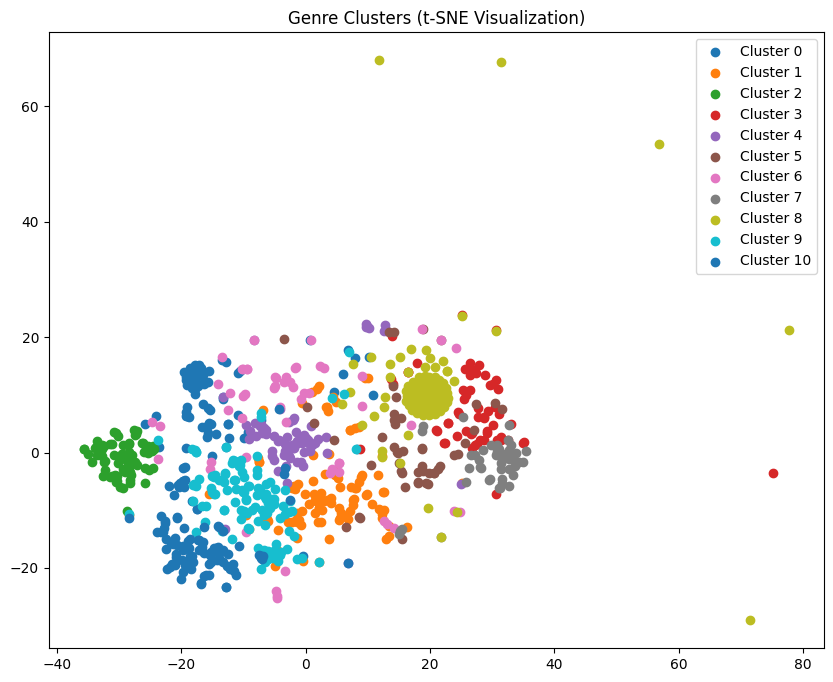

Cluster
0     [regional mexican, canadian country, disco hou...
1     [retro electro, electro, jangle rock, funk car...
2     [technical brutal death metal, german metal, c...
3     [minecraft, c86, madchester, pagode, breakcore...
4     [harp, new orleans jazz, orchestra, harmonica ...
5     [samba, operetta, rumba, carnaval, nova mpb, p...
6     [smooth soul, martial industrial, chill groove...
7     [brutal deathcore, nwobhm, post-grunge, melodi...
8     [lilith, post-screamo, shanty, ukhc, j-indie, ...
9     [psychedelic rock, pop rap, soul, pinoy rock, ...
10    [belgian pop, russian folk, indonesian indie, ...
Name: Genre, dtype: object


In [51]:

# --- Clustering (example using KMeans) ---
n_clusters = 11  
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)  # Set n_init explicitly
kmeans.fit(genre_embeddings)
cluster_labels = kmeans.labels_

# --- Visualization (using t-SNE for dimensionality reduction) --- 
tsne = TSNE(n_components=2, random_state=42) 
embeddings_2d = tsne.fit_transform(genre_embeddings)

plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(embeddings_2d[cluster_labels == i, 0], 
                embeddings_2d[cluster_labels == i, 1], 
                label=f'Cluster {i}')

plt.title('Genre Clusters (t-SNE Visualization)')
plt.legend()
plt.show()

# --- Create DataFrame for inspection and manual adjustment ---
df = pd.DataFrame({'Genre': all_genres, 'Cluster': cluster_labels})
print(df.groupby('Cluster')['Genre'].apply(list))

## Genre Hierarchy and Parent Genre Assignment

### Genre Hierarchy
- **Purpose**: Assign a parent genre to each child genre to create a hierarchical structure for genre classification.
- **Structure**: The hierarchy categorizes genres into broad parent genres with specific sub-genres under each category.

### Steps

1. **Flatten Genre Hierarchy**:
   - Create a mapping (`genre_to_parent`) that associates each specific genre with its parent genre.
   - Iterate through the hierarchy to build this mapping.

2. **Assign Parent Genres**:
   - Define a function to map each genre in the dataset to its parent genre using the `genre_to_parent` mapping.
   - Handle cases where multiple parent genres might apply by returning a comma-separated list.

3. **Apply Assignment**:
   - Apply the function to the `id_genres` DataFrame to add a new column (`parent_genre_new`) with the assigned parent genres.

### Output
- **DataFrame**: Updated `id_genres` DataFrame with a new column for the parent genre of each entry.



In [52]:
# Genre Hierarchy is used to assign parent level Genre to all child level genre 

genre_hierarchy = {
    'Rock' : {
    'Hardcore/Punk': ['hardcore punk', 'punk', 'melodic hardcore', 'hardcore', 'grindcore', 'pop punk', 'screamo', 'anarcho-punk', 'oi', 'straight edge', 'hardcore punk', 'post-hardcore', 'mathcore', 'skate punk', 'crust punk', 'power violence', 'dark hardcore', 'riot grrrl', 'chaotic hardcore', 'nyhc', 'dc hardcore', 'boston hardcore', 'easycore', 'post-screamo', 'nintendocore'], 
    'Progressive/Experimental Metal': ['djent', 'stoner rock', 'post-rock', 'krautrock', 'space rock', 'psychedelic doom', 'gothic doom', 'atmospheric doom', 'progressive doom', 'funeral doom'], 
    'Classic/Hard Rock': ['classic rock', 'hard rock', 'glam rock', 'blues-rock', 'sleaze rock', 'heartland rock', 'southern rock', 'pub rock', 'album rock', 'modern hard rock', 'christian hard rock', 'melodic hard rock'], 
    'Alternative/Indie Rock': ['post-punk', 'new wave', 'indie rock', 'shoegaze', 'alternative rock', 'lo-fi', 'garage rock', 'dream pop', 'britpop', 'grunge', 'spanish rock', 'gothic rock', 'madchester', 'no wave', 'noise rock', 'j-rock', 'folk rock', 'emo', 'alternative pop', 'indie folk', 'brazilian rock', 'post-grunge', 'noise pop', 'rock nacional', 'new weird america', 'jangle pop', 'country rock', 'emo punk', 'folk punk', 'math rock', 'rockabilly', 'indie punk', 'punk blues', 'freakbeat', 'shoegaze', 'dream pop', 'dark wave', 'slowcore', 'emo', 'twee pop', 'chamber pop', 'jangle pop', 'post-rock', 'noise pop', 'indie pop', 'dreamgaze', 'surf music', 'anti-folk', 'c86', 'garage pop', 'nu gaze', 'grunge pop', 'cowpunk', 'noise punk', 'jangle rock']
    },
    
    'Metal' : {
    'Heavy Metal': [ 'atmospheric sludge', 'crossover thrash', 'blackened hardcore', 'black thrash', 'black death','symphonic metal', 'gothic metal', 'power metal', 'death metal', 'thrash metal', 'speed metal', 'black metal', 'viking metal', 'folk metal', 'melodic death metal', 'brutal death metal', 'technical death metal', 'symphonic black metal', 'atmospheric black metal', 'melodic black metal', 'depressive black metal', 'raw black metal', 'swedish black metal', 'finnish black metal', 'norwegian black metal', 'canadian black metal', 'greek black metal', 'polish black metal', 'technical brutal death metal', 'industrial black metal', 'symphonic death metal', 'progressive black metal', 'swedish death metal', 'drone metal', 'experimental black metal', 'avant-garde black metal', 'cosmic black metal', 'gothic symphonic metal', 'technical black metal', 'sludge metal'], 
    'Hardcore/Punk': ['metalcore', 'nu metal', 'metallic hardcore'], 
    'Progressive/Experimental Metal': ['progressive metal', 'doom metal', 'drone metal', 'post-metal', 'stoner metal', 'instrumental progressive metal', 'post-black metal', 'sludge metal', 'dub metal'], 
    'Classic/Hard Rock': ['glam metal']
    },

    'Electronic/Dance': {
        'House/Techno': ['trance', 'techno', 'house', 'electro', 'minimal techno', 'minimal', 'electro house', 'deep house', 'tech house', 'progressive house', 'future house', 'minimal', 'breakbeat', 'eurodance', 'dub techno', 'fidget house', 'hip house', 'tribal house', 'deep vocal house', 'italo house', 'acid techno', 'dutch house', 'uk house', 'disco house', 'jump up', 'hard house'], 
        'Trance/Psytrance': ['trance', 'vocal trance', 'progressive trance', 'hard trance', 'psychedelic trance', 'uplifting trance', 'goa trance', 'deep progressive trance'],
        'Ambient/Chillwave': ['ambient', 'downtempo', 'chillwave', 'electronica', 'dark ambient', 'ambient techno', 'space ambient', 'ambient industrial', 'experimental ambient', 'deep ambient', 'dronescape'],
        'EDM': ['edm', 'big room', 'trap music', 'complextro', 'dubstep', 'brostep', 'electro house', 'trap latino', 'future bass', 'moombahton', 'bass music', 'wonky'], 
        'Drum & Bass/Breakbeat': ['drum and bass', 'breakcore', 'jungle', 'breakbeat', 'breaks', 'ragga jungle', 'drill and bass', 'hardcore breaks'],
        'Electro/Industrial': ['electroclash', 'ebm', 'electro-industrial', 'aggrotech', 'industrial metal', 'industrial', 'industrial rock', 'futurepop', 'power noise', 'digital hardcore', 'martial industrial', 'cyber metal'],
        'Other Electronic': ['synthpop', 'electropop', 'nu disco', 'disco', 'chiptune', 'video game music', '8-bit', 'c64', 'retro electro', 'electro swing']
    },
    
    'Pop': {
        'Mainstream Pop': ['pop', 'k-pop', 'j-pop', 'teen pop', 'bubblegum pop', 'eurovision', 'french pop', 'portuguese pop', 'italian pop', 'spanish pop', 'uk pop', 'mexican pop', 'albanian pop', 'bulgarian pop', 'greek pop', 'kazakh pop', 'lithuanian pop', 'polish pop', 'romanian pop', 'russian pop', 'swedish pop', 'taiwan pop', 'turkish pop', 'talent show', 'girl group', 'boy band', 'idol', 'bedroom pop', 'operatic pop', 'baroque pop', 'sunshine pop'], 
        'Country Pop': ['country', 'contemporary country', 'country pop', 'mpb', 'sertanejo'], 
        'Latin Pop': ['latin pop', 'reggaeton', 'bachata', 'merengue']
    },
    'World Music': {
        'Latin': ['salsa', 'samba', 'forro', 'latin', 'cumbia', 'ranchera', 'tejano', 'vallenato', 'bolero', 'morna', 'tropical', 'brega', 'pagode', 'cumbia villera', 'grupera', 'sertanejo universitario', 'cumbia chilena', 'cumbia pop', 'salsa cubana', 'latin jazz', 'choro', 'bossa nova', 'tecnobrega', 'nueva cancion', 'mariachi', 'flamenco', 'rumba', 'bachata', 'merengue', 'batida'],
        'Celtic': ['celtic', 'celtic rock', 'celtic metal', 'irish folk', 'scottish folk'],
        'Other World': ['world', 'afrobeat', 'bhangra', 'punjabi', 'rai', 'opm', 'turkish pop', 'turkish folk', 'afrikaans', 'nova mpb', 'celtic', 'mandopop', 'gamelan', 'klezmer'] # Add other world music subgenres here 
    },
    'Urban/Hip-Hop': {
        'Hip-Hop': ['hip hop', 'underground hip hop', 'rap', 'crunk', 'southern hip hop', 'emo rap', 'trap music', 'gangster rap', 'hardcore hip hop', 'turntablism', 'alternative hip hop', 'experimental hip hop', 'country rap', 'new jack swing', 'pop rap', 'ska punk', 'horrorcore', 'nerdcore', 'abstract hip hop', 'east coast hip hop', 'houston rap', 'irish hip hop', 'nigerian hip hop', 'polish hip hop', 'french hip hop', 'chinese hip hop', 'uk hip hop', 'spanish hip hop', 'latin hip hop', 'trap argentino', 'bounce', 'meme rap'], 
        'R&B': ['rhythm and blues']
    },
    'R&B/Soul': {
        'Soul': ['soul', 'classic soul', 'northern soul', 'motown', 'smooth soul', 'neo soul', 'philly soul', 'southern soul', 'swedish soul', 'chicago soul', 'retro soul', 'lovers rock', 'quiet storm'],
        'Funk': ['funk', 'funk metal', 'funk rock', 'jazz funk', 'deep funk', 'funk carioca', 'gospel funk', 'afro-funk']
    },
    'Folk & Traditional': {
        'Folk': ['folk', 'ambient folk', 'indie folk', 'folk rock', 'folk punk', 'folk-pop', 'psychedelic folk', 'freak folk', 'free folk', 'nordic folk', 'contemporary folk', 'british folk', 'american folk', 'celtic folk', 'medieval folk'], 
        'Singer-Songwriter': ['singer-songwriter', 'cantautor'], 
        'Bluegrass': ['bluegrass', 'progressive bluegrass']
    },
    'Classical & Instrumental': {
        'Classical': ['classical', 'contemporary classical', 'neoclassical', 'neo-classical', 'early music', 'renaissance', 'baroque', 'piano', 'orchestral', 'chamber music'],
        'Jazz': ['jazz', 'bebop', 'free jazz', 'jazz fusion', 'avant-garde jazz', 'vocal jazz', 'jazz piano', 'nu jazz', 'jazz blues', 'jazz metal', 'jazz rap', 'latin jazz', 'avant-garde jazz', 'smooth jazz', 'cool jazz', 'acid jazz', 'jazz funk', 'new orleans jazz', 'gypsy jazz', 'spiritual jazz', 'french jazz', 'polish jazz', 'ethio-jazz', 'jazz trio', 'jazz guitar', 'jazz violin', 'jazz saxophone', 'jazz trumpet'],
        'Instrumental': ['accordion', 'banjo', 'harp', 'violin', 'cello', 'sitar', 'harpsichord', 'instrumental rock', 'guitar', 'piano', 'strings']
    },
    'Blues & Jazz': {
        'Blues': ['blues', 'electric blues', 'delta blues', 'chicago blues', 'country blues', 'swamp blues', 'piedmont blues', 'gospel blues', 'harmonica blues', 'jump blues', 'punk blues', 'modern blues'],
        'Jazz': ['jazz', 'bebop', 'free jazz', 'jazz fusion', 'avant-garde jazz', 'vocal jazz', 'big band', 'swing', 'ragtime', 'jazz piano', 'nu jazz', 'acid jazz', 'jazz funk', 'new orleans jazz']
    },
    'Experimental & Avant-Garde': {
        'Experimental': ['experimental', 'drone', 'free improvisation', 'noise', 'witch house', 'minimal wave', 'avant-garde', 'noise rock', 'experimental hip hop', 'experimental rock', 'experimental pop', 'experimental electronic', 'experimental ambient', 'musique concrete', 'sound collage', 'lowercase'],
        'Avant-Garde': ['avant-garde', 'free jazz', 'avant-garde jazz', 'avant-garde metal']
    },
    'Stage & Screen': {
        'Soundtrack': ['soundtrack'],
        'Broadway': ['broadway'],
        'Disney': ['disney'],
        'Video Game Music': ['video game music', 'chiptune', '8-bit']
    },
    'Other': {
        'Spoken Word': ['spoken word', 'poetry', 'comedy'],
        'Religious': ['christian rock', 'gospel', 'praise', 'worship', 'christian metal', 'christian pop', 'christian hardcore', 'ccm', 'gospel', 'christian music', 'worship', 'adoracao', 'lds'],
        'Miscellaneous': ['easy listening', 'lounge', 'new age', 'beats', 'axe', 'football', 'halloween', 'christmas', 'meditation', 'yoga', 'sleep', 'tone', 'motivation', 'guidance', 'healing', 'lullaby', 'ringtone', 'theme']
    }
}

# Step 1: Flatten the genre hierarchy
genre_to_parent = {}

for parent, subcategories in genre_hierarchy.items():
    for subcategory, genres in subcategories.items():
        for genre in genres:
            genre_to_parent[genre] = parent

# Step 2: Assign parent genre based on the genres in the dataset
def assign_parent_label(genres_str):
    genres = genres_str.split(',')
    parent_labels = set()
    
    for genre in genres:
        genre = genre.strip().lower()
        if genre in genre_to_parent:
            parent_labels.add(genre_to_parent[genre])
    
    # If multiple parent labels, we can return them as a list, or a string concatenated with commas
    return ','.join(parent_labels) if parent_labels else 'Unknown'

# Apply the function to the dataframe
id_genres['parent_genre_new'] = id_genres['genres'].apply(assign_parent_label)

print(df)


                            Genre  Cluster
0                brutal deathcore        7
1    technical brutal death metal        2
2                regional mexican        0
3                psychedelic rock        9
4                   retro electro        1
..                            ...      ...
848                        glitch        8
849                  funeral doom        0
850         symphonic black metal        2
851                     glam rock        9
852                  country rock        9

[853 rows x 2 columns]


In [53]:
id_genres

id                                             genres  \
0       0009fFIM1eYThaPg                                                pop   
1       0010xmHR6UICBOYT                                underground hip hop   
2       002Jyd0vN4HyCpqL                        hard rock,rock,classic rock   
3       006TYKNjNxWjfKjy  symphonic metal,power metal,symphonic power metal   
4       007LIJOPQ4Sb98qV                                 post-punk,new wave   
...                  ...                                                ...   
109264  zzyyPUs7hC9Nz2e1                        hardcore punk,punk,hardcore   
109265  zzz0n04uuTUA7fNh                                                pop   
109266  zzzj3LYaZtYtbzSr                                  singer-songwriter   
109267  zzznMjZAKnJJXQSj                                 synthpop,remix,pop   
109268  zzzwh2ktIWjsR7xp                   indie rock,alternative rock,rock   

            parent_genre_new  
0                        Pop  
1              Urban/Hip-Hop  
2                       Rock  
3                      Metal  
4                       Rock  
...                      ...  
109264                  Rock  
109265                   Pop  
109266    Folk & Traditional  
109267  Pop,Electronic/Dance  
109268                  Rock  

[109269 rows x 3 columns]

## Extracting and Displaying Unique Genres

In [54]:
unique_classes = set()
for genres in id_genres['parent_genre_new']:
    # Split by comma and add to set
    genre_list = [genre.strip() for genre in genres.split(',')]
    unique_classes.update(genre_list)

# Convert set to list and sort
unique_classes = sorted(list(unique_classes))

# Display the unique classes / Genres
unique_classes

['Blues & Jazz',
 'Classical & Instrumental',
 'Electronic/Dance',
 'Experimental & Avant-Garde',
 'Folk & Traditional',
 'Metal',
 'Other',
 'Pop',
 'R&B/Soul',
 'Rock',
 'Stage & Screen',
 'Unknown',
 'Urban/Hip-Hop',
 'World Music']

In [55]:

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('stopwords')
        

# Load metddata and language dataset
id_metadata = pd.read_csv('D:/University of Sheffield/Final Project/Datasets/Test/music4all_no_audio/music4all_no_audio/id_metadata.csv', sep='\t')
id_lang = pd.read_csv('D:/University of Sheffield/Final Project/Datasets/Test/music4all_no_audio/music4all_no_audio/id_lang.csv', sep='\t')

# Function to load lyrics
def load_lyrics(lyrics_zip_path, num_files):
    lyrics_dict = {}

    # Open the ZIP file
    with zipfile.ZipFile(lyrics_zip_path, 'r') as zip_ref:
        # Get the list of files in the ZIP archive
        files = zip_ref.namelist()[:num_files]

        for file in tqdm(files, desc="Loading lyrics"):
            # Open and read each file
            with zip_ref.open(file) as f:
                lyrics = f.read().decode('utf-8').strip()

                song_id = os.path.basename(file).replace('.txt', '')
                lyrics_dict[song_id] = lyrics

    return lyrics_dict

# Path to the ZIP file
lyrics_zip_path = 'D:/University of Sheffield/Final Project/Datasets/Test/music4all_no_audio/music4all_no_audio/lyrics.zip'

# Load lyrics
lyrics_dict = load_lyrics(lyrics_zip_path, num_files=109269)

# Create a DataFrame from the lyrics dictionary
lyrics_df = pd.DataFrame(list(lyrics_dict.items()), columns=['id', 'lyrics']) 

# Merge data
data = lyrics_df.merge(id_metadata, on='id', how='inner')\
                .merge(id_lang, on='id', how='inner')
data

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Loading lyrics: 100%|███████████████████████████████████████████████████████| 109269/109269 [00:08<00:00, 12575.02it/s]


id                                             lyrics  \
0       0009fFIM1eYThaPg  It's a sunny day, so I got nowhere to hide\nNo...   
1       0010xmHR6UICBOYT  You might think my words are gift wrapped\nPut...   
2       002Jyd0vN4HyCpqL  Goering's on the phone to Freiburg\nSay's Will...   
3       006TYKNjNxWjfKjy  My princess why must I assist at your death\nI...   
4       007LIJOPQ4Sb98qV  Absorbing your words\nBattles raging within me...   
...                  ...                                                ...   
109264  zzz0n04uuTUA7fNh  Girl you don't know how I feel (how I really f...   
109265  zzzj3LYaZtYtbzSr  wwI, oh, must go on standing\nYou can't break ...   
109266  zzznMjZAKnJJXQSj  Talkin' in my sleep at night\nMakin' myself cr...   
109267  ZZZS8RD8VFhzYLJ6  Men in white coats\nRing the changes\nCall us ...   
109268  zzzwh2ktIWjsR7xp  It's the price I guess\nfor the lies I've told...   

                    spotify_id  popularity  release  danceability  energy  \
0       3eObKIfHKJ1nAPh0wTxFCc        12.0     2009         0.635   0.746   
1       27szvF97Tu95GxN98N52fy        46.0     2013         0.591   0.513   
2       273lBFpxUCwisTpdnF9cVb        31.0     1974         0.319   0.925   
3       1qZgergQ41vaD4zBf3AKXR        33.0     2017         0.432   0.979   
4       6rVxJ3sN3Cz40MSLavbG1K        19.0     2009         0.357   0.708   
...                        ...         ...      ...           ...     ...   
109264  21pCToQdqcPi879auxjxKe        48.0     2014         0.572   0.503   
109265  2SJ6FGmRPacKE9N4g4BRZU        21.0     2010         0.402   0.376   
109266  2ygfHXyt3gvyhvKrNJU61n        47.0     2017         0.532   0.977   
109267  7EMoSEOUoS90lQdXll2mak        13.0     2010         0.528   0.826   
109268  7pz9FnXkQd0MH9Ms3358Cj        27.0     2011         0.430   0.817   

         key  mode  valence    tempo  duration_ms lang  
0        6.0   1.0    0.548  110.973       229947   en  
1        7.0   0.0    0.263  172.208       325096   en  
2        2.0   1.0    0.658  157.630       285693   en  
3        7.0   1.0    0.162   90.008       332867   en  
4        9.0   1.0    0.470  123.904       326067   en  
...      ...   ...      ...      ...          ...  ...  
109264   6.0   0.0    0.553  103.215       262840   en  
109265   2.0   0.0    0.119  108.509       276507   en  
109266  10.0   0.0    0.966  116.527       224549   en  
109267   0.0   1.0    0.182  123.012       299746   en  
109268   0.0   1.0    0.174  138.985       239627   en  

[109269 rows x 13 columns]

## Text Pre-Processing Pipeline

- **Setup**: Initialize `stop_words` and `lemmatizer` to standardize text preprocessing steps.

- **Cleaning Lyrics**: 
  - Convert lyrics to lowercase.
  - Remove numbers, punctuation, and extra spaces.
  - Tokenize, lemmatize, and remove stop words.

- **Additional Cleaning**: 
  - Exclude instrumental pieces and non-ASCII characters.
  - Remove empty or null lyrics entries.
  - Filter the dataset to include only English-language songs.

- **Remove Repetitions**: 
  - Eliminate repeated lines or words to reduce redundancy.

- **Sentiment Analysis**: 
  - Calculate sentiment polarity of each song using `TextBlob`.

- **Create Processed DataFrame**: 
  - Merge cleaned lyrics with language data and apply the above cleaning functions.

- **Output**: 
  - Display the size and preview of the cleaned DataFrame to verify preprocessing results.


In [56]:

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_lyrics(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    # Lemmatize the words first
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    stop_words = set(stopwords.words('english'))
    return ' '.join(word for word in text.split() if word not in stop_words)

# Function to apply additional cleaning steps
def additional_cleaning_steps(df):
    # Remove any songs without lyrics (e.g., instrumental pieces)
    df = df[df['lyrics'].str.strip().str.lower() != 'instrumental']
    # Remove corrupted/non-ASCII characters
    df = df[~df['lyrics'].str.contains(r'[^\x00-\x7F]+')]
    # Remove empty lyrics
    df = df[df['lyrics'].str.strip() != '']
    # Remove null values
    df = df.dropna(subset=['lyrics'])
    # Filter to keep only rows where 'lang' is 'en' (English)
    df = df[df['lang'] == 'en']
    return df

# Function to remove repetitions in lyrics
def remove_repetitions(text):
    words = text.split()
    return ' '.join(sorted(set(words), key=words.index))

def get_sentiment(text):
    # Calculate sentiment polarity using TextBlob
    return TextBlob(text).sentiment.polarity

# Create a DataFrame from the lyrics dictionary
lyrics_df = pd.DataFrame(list(lyrics_dict.items()), columns=['id', 'lyrics'])

# Apply the cleaning function to the lyrics column
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(clean_lyrics)

# Remove repeated lines in lyrics
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(remove_repetitions)

# Merge the language information into lyrics_df
lyrics_df = pd.merge(lyrics_df, data[['id', 'lang']], on='id', how='left')

# Apply additional cleaning steps
lyrics_df = additional_cleaning_steps(lyrics_df)

# Calculate sentiment for each song
lyrics_df['sentiment'] = lyrics_df['lyrics'].apply(get_sentiment)

# Print the final DataFrame shape and a sample of the results
print(f"Number of records in lyrics_df: {len(lyrics_df)}")
print(lyrics_df.shape)
print(lyrics_df.head())



Number of records in lyrics_df: 82457
(82457, 4)
                 id                                             lyrics lang  \
0  0009fFIM1eYThaPg  sunny day got nowhere hide cloud sky im preten...   en   
1  0010xmHR6UICBOYT  might think words gift wrapped putting positiv...   en   
2  002Jyd0vN4HyCpqL  goerings phone freiburg says willies done quit...   en   
3  006TYKNjNxWjfKjy  princess must assist death cant endure tragic ...   en   
4  007LIJOPQ4Sb98qV  absorbing words battles raging within graduall...   en   

   sentiment  
0   0.074256  
1  -0.043766  
2   0.009264  
3  -0.039000  
4  -0.021429  


In [57]:
# Filter out rows where 'parent_genre_new' contains more than one genre 
filtered_id_genres = id_genres[~id_genres['parent_genre_new'].str.contains(',')]

# Display the first few rows of the filtered DataFrame
filtered_id_genres


id                                             genres  \
0       0009fFIM1eYThaPg                                                pop   
1       0010xmHR6UICBOYT                                underground hip hop   
2       002Jyd0vN4HyCpqL                        hard rock,rock,classic rock   
3       006TYKNjNxWjfKjy  symphonic metal,power metal,symphonic power metal   
4       007LIJOPQ4Sb98qV                                 post-punk,new wave   
...                  ...                                                ...   
109262  zzx8CWdM7qkxKQpC                                         indie rock   
109264  zzyyPUs7hC9Nz2e1                        hardcore punk,punk,hardcore   
109265  zzz0n04uuTUA7fNh                                                pop   
109266  zzzj3LYaZtYtbzSr                                  singer-songwriter   
109268  zzzwh2ktIWjsR7xp                   indie rock,alternative rock,rock   

          parent_genre_new  
0                      Pop  
1            Urban/Hip-Hop  
2                     Rock  
3                    Metal  
4                     Rock  
...                    ...  
109262                Rock  
109264                Rock  
109265                 Pop  
109266  Folk & Traditional  
109268                Rock  

[81302 rows x 3 columns]

In [58]:
# Drop original genres column
merged_df = pd.merge(filtered_id_genres, lyrics_df, on='id', how='inner')
merged_df = merged_df.drop(columns=['genres'])
merged_df

id    parent_genre_new  \
0      0009fFIM1eYThaPg                 Pop   
1      0010xmHR6UICBOYT       Urban/Hip-Hop   
2      002Jyd0vN4HyCpqL                Rock   
3      006TYKNjNxWjfKjy               Metal   
4      007LIJOPQ4Sb98qV                Rock   
...                 ...                 ...   
62259  zzx8CWdM7qkxKQpC                Rock   
62260  zzyyPUs7hC9Nz2e1                Rock   
62261  zzz0n04uuTUA7fNh                 Pop   
62262  zzzj3LYaZtYtbzSr  Folk & Traditional   
62263  zzzwh2ktIWjsR7xp                Rock   

                                                  lyrics lang  sentiment  
0      sunny day got nowhere hide cloud sky im preten...   en   0.074256  
1      might think words gift wrapped putting positiv...   en  -0.043766  
2      goerings phone freiburg says willies done quit...   en   0.009264  
3      princess must assist death cant endure tragic ...   en  -0.039000  
4      absorbing words battles raging within graduall...   en  -0.021429  
...                                                  ...  ...        ...  
62259  innocence dont come easy sense never accidents...   en  -0.076915  
62260  cant cut heart cold ground stood like tombston...   en  -0.215894  
62261  girl dont know feel really since away oh baby ...   en   0.110823  
62262  wwi oh must go standing cant break isnt im cho...   en  -0.400000  
62263  price guess lies ive told truth longer thrills...   en   0.275000  

[62264 rows x 5 columns]

## Calculating and Visualizing Genre Counts

### Calculating Genre Counts

Class Distribution:
parent_genre_new
Rock                          25436
Pop                            9454
Metal                          6656
Unknown                        4949
Electronic/Dance               4284
Folk & Traditional             3859
Urban/Hip-Hop                  2720
R&B/Soul                       2252
Blues & Jazz                    904
Experimental & Avant-Garde      797
Stage & Screen                  500
Other                           310
World Music                      83
Classical & Instrumental         60
Name: count, dtype: int64


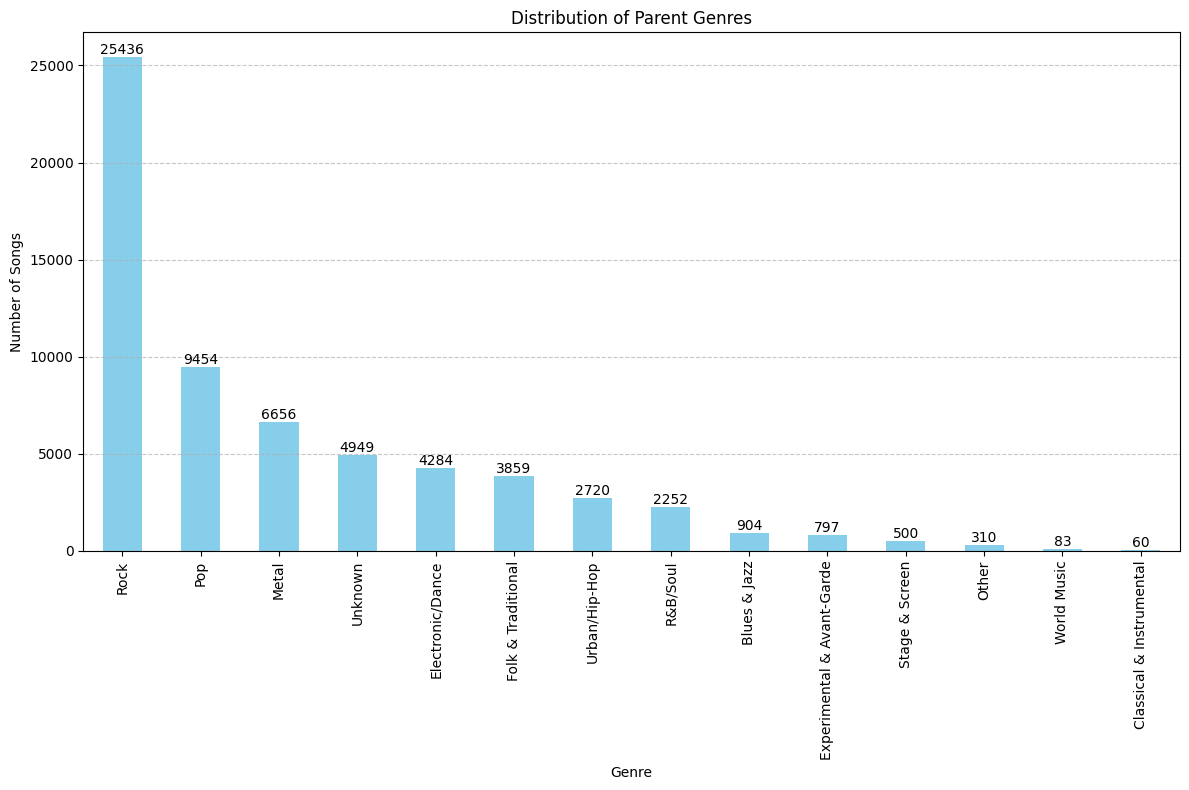

In [59]:

# Calculate and print the genre counts
genre_counts = merged_df['parent_genre_new'].value_counts()
print("Class Distribution:")
print(genre_counts)

# Plot the genre counts
plt.figure(figsize=(12, 8))
ax = genre_counts.plot(kind='bar', color='skyblue')

# Adding counts on the bars
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height() + 0.5, f'{int(i.get_height())}',
            ha='center', va='bottom')

plt.title('Distribution of Parent Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Calculating and Visualizing Average Word Count Per Genre

### Calculating Word Count

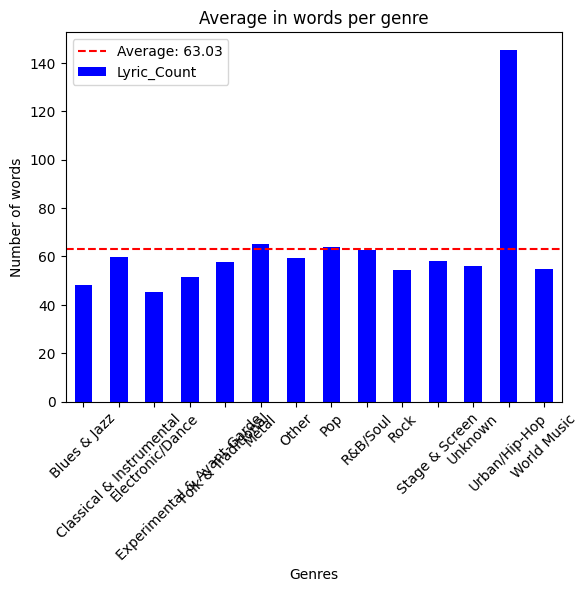

In [60]:
import matplotlib.pyplot as plt

plot_df = merged_df.groupby('parent_genre_new')['lyrics'].count().sort_values(ascending=False).head(10)

# Calculate the word count for each lyric
merged_df['Lyric_Count'] = merged_df['lyrics'].map(lambda x: len(x.split()))

# Group by 'Genres' and calculate the mean word count per genre
plot_df = merged_df.groupby('parent_genre_new')['Lyric_Count'].mean()

# Create a bar plot
ax = plot_df.plot(kind='bar', color='blue', title='Average in words per genre')

# Set labels and title
plt.xlabel('Genres')
plt.ylabel('Number of words')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Calculate the overall mean word count
overall_mean = plot_df.mean()

# Add a horizontal line for the overall mean
plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Average: {overall_mean:.2f}')

# Add a legend
plt.legend()

# Show the plot
plt.show()


## Visualizing Top 10 Genres by Average Lyric Length

### Sorting and Plotting Average Lyric Count

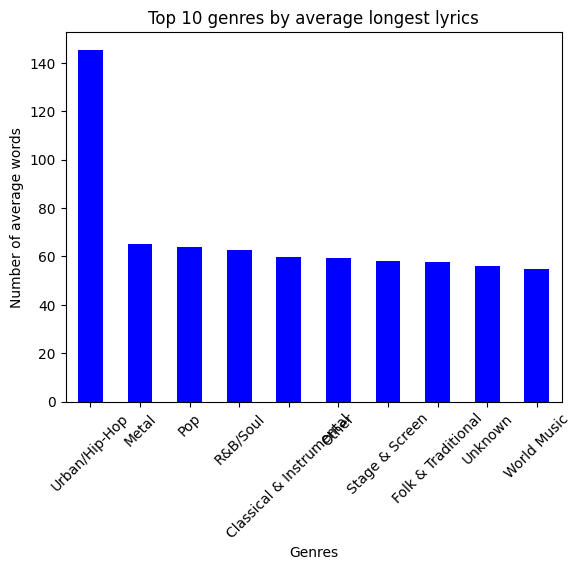

In [61]:

# Sort the values in descending order and select the top 10 genres with the longest average lyrics.
plot_df = merged_df.groupby('parent_genre_new')['Lyric_Count'].mean().sort_values(ascending=False).head(10)

# Plot the results as a bar chart with the genre names on the x-axis and average lyric counts on the y-axis.
# The chart will display the top 10 genres by their average lyric length.
ax = plot_df.plot(kind='bar', color='blue', title='Top 10 Genres by Average Longest Lyrics')

# Set the x-axis label to 'Genres'.
plt.xlabel('Genres')

# Set the y-axis label to 'Number of average words'.
plt.ylabel('Number of Average Words')

# Rotate the x-axis labels by 45 degrees for better readability.
plt.xticks(rotation=45)

# Display the plot.
plt.show()


## Visualizing Top 10 Genres by Average Shortest Lyrics

### Sorting and Plotting Average Lyric Count

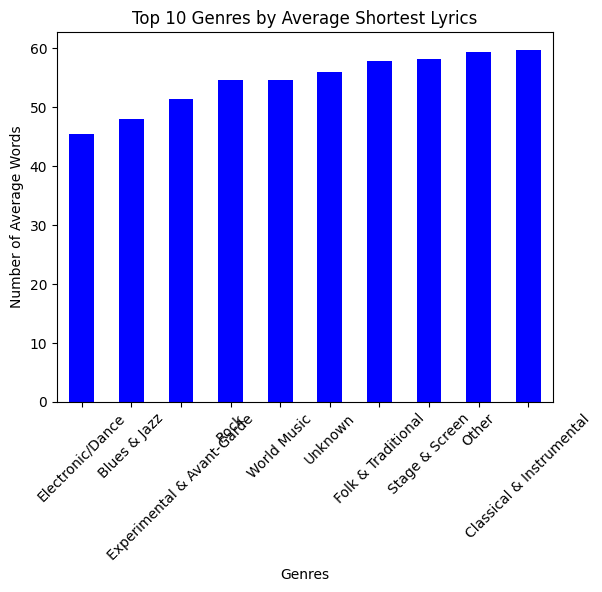

In [62]:

# Sort the values in ascending order and select the top 10 genres with the shortest average lyrics.
plot_df = merged_df.groupby('parent_genre_new')['Lyric_Count'].mean().sort_values(ascending=True).head(10)

# Plot the results as a bar chart with the genre names on the x-axis and average lyric counts on the y-axis.
# The chart will display the top 10 genres with the shortest average lyrics.
ax = plot_df.plot(kind='bar', color='blue', title='Top 10 Genres by Average Shortest Lyrics')

# Set the x-axis label to 'Genres'.
plt.xlabel('Genres')

# Set the y-axis label to 'Number of Average Words'.
plt.ylabel('Number of Average Words')

# Rotate the x-axis labels by 45 degrees for better readability.
plt.xticks(rotation=45)

# Display the plot.
plt.show()


## Exploratory Data Analysis (EDA): Word Clouds for Each Genre

### Generating Word Clouds

1. **Reset DataFrame Index:**
   - The index of the `merged_df` DataFrame is reset to ensure a clean and sequential index.

2. **Word Cloud Visualization:**
   - A function `plot_wordcloud` is defined to generate word clouds for text data.
   - The function takes text input and optionally a title to create and display a word cloud with the specified configuration (e.g., width, height, background color, max words).

3. **Creating Word Clouds by Genre:**
   - For each unique genre in the dataset, the lyrics are combined into a single string.
   - The `plot_wordcloud` function is called to generate and display a word cloud for the lyrics of each genre, with the genre name included in the title.

This visualization provides insights into the most frequent words used in lyrics for different genres, offering a visual summary of genre-specific language trends.


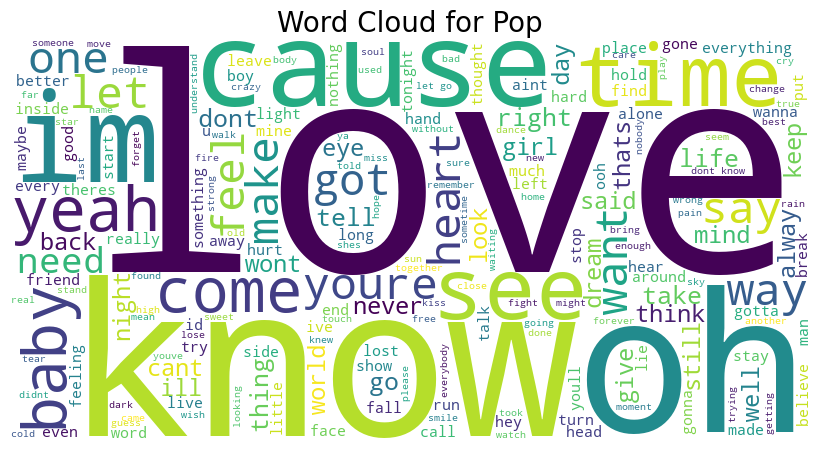

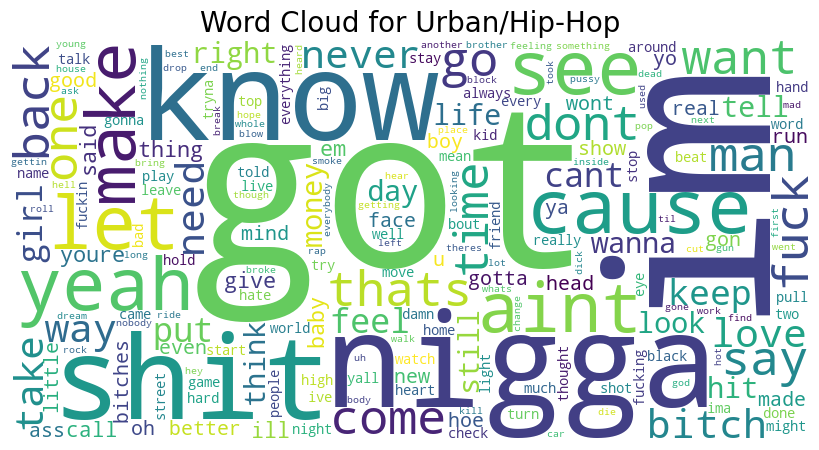

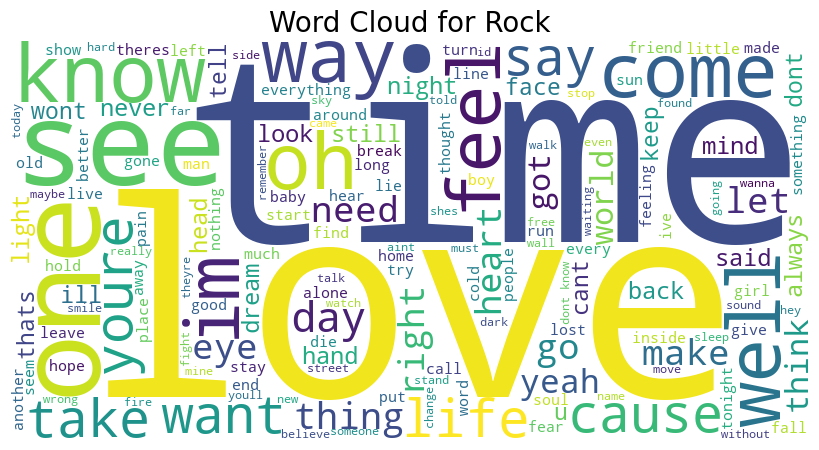

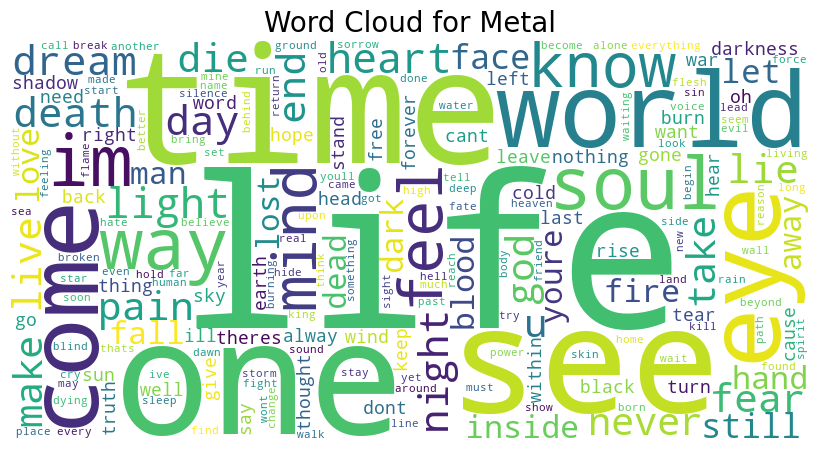

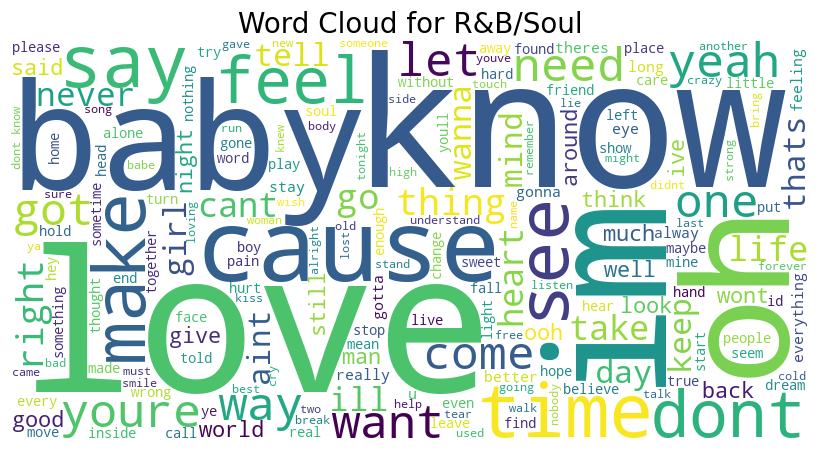

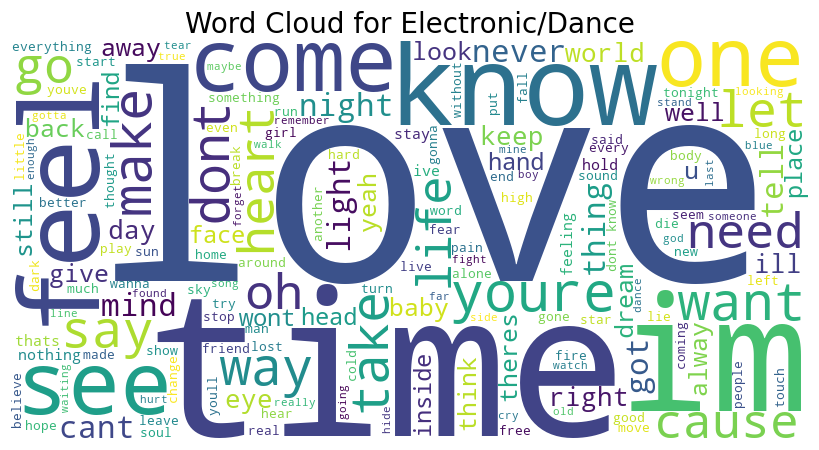

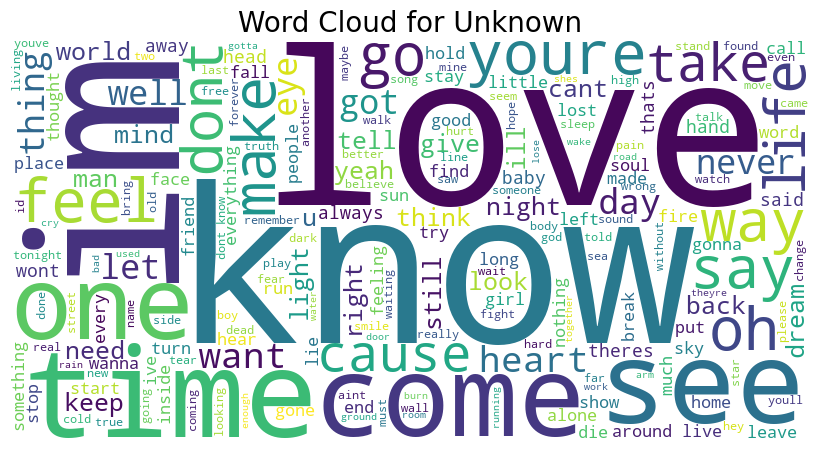

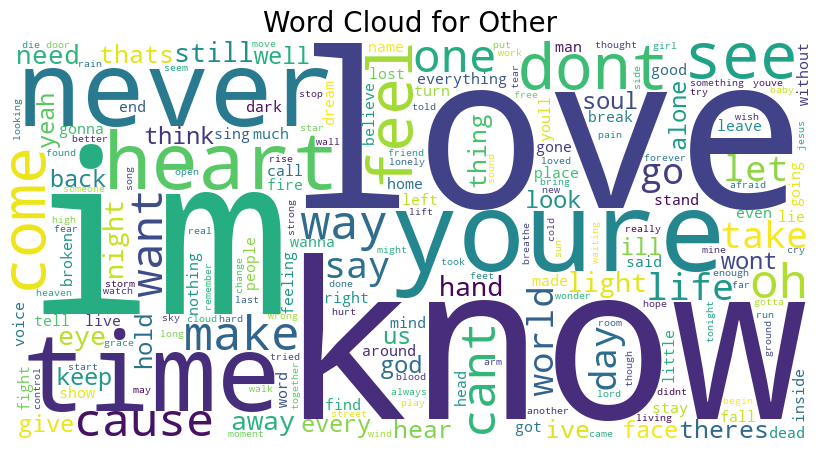

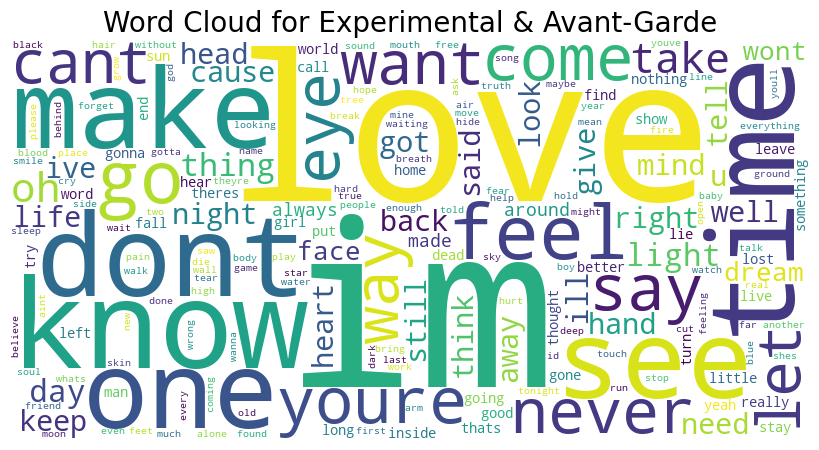

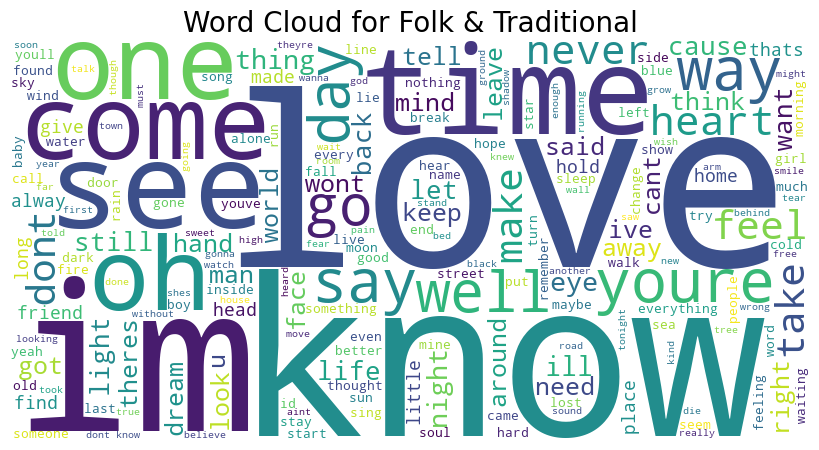

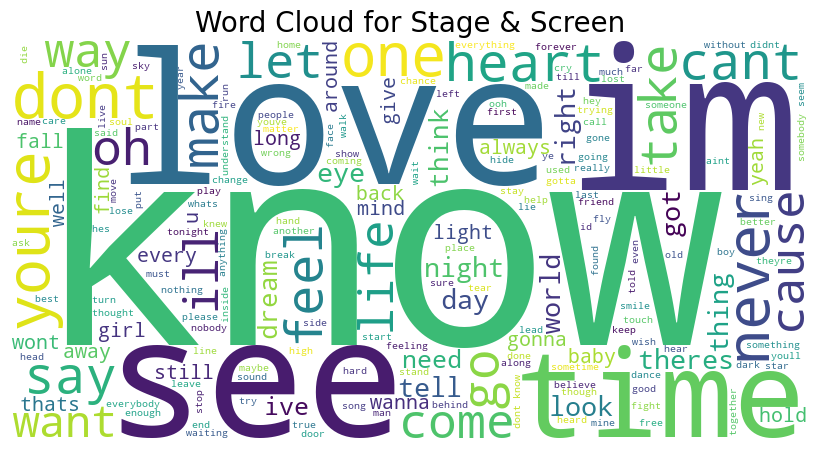

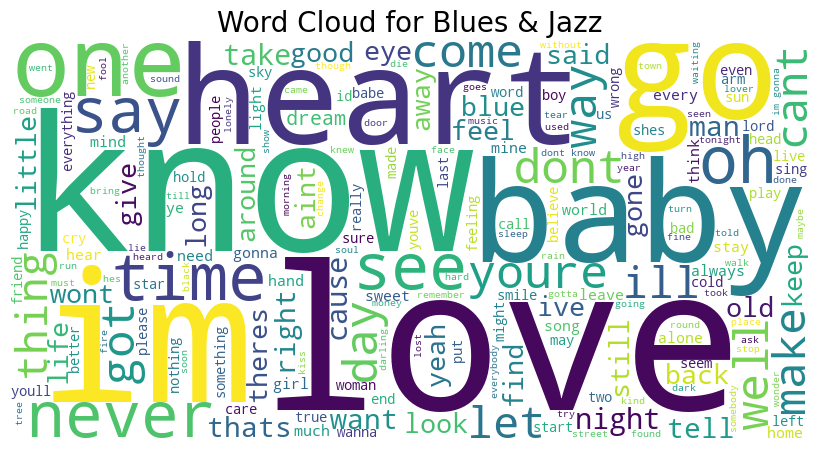

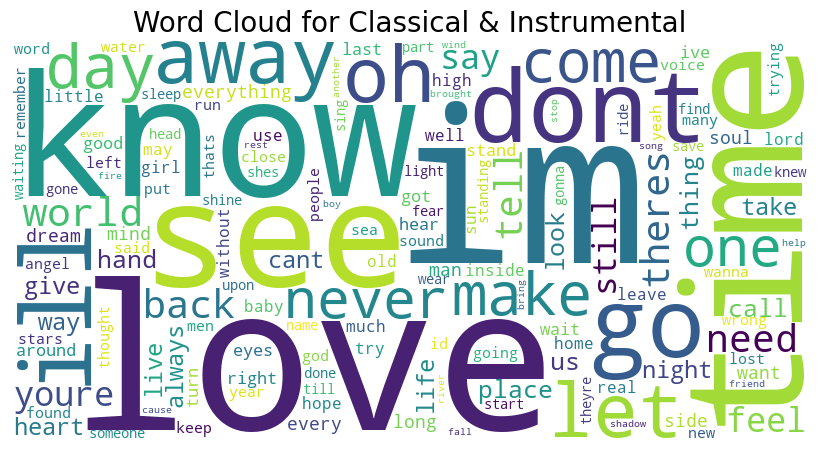

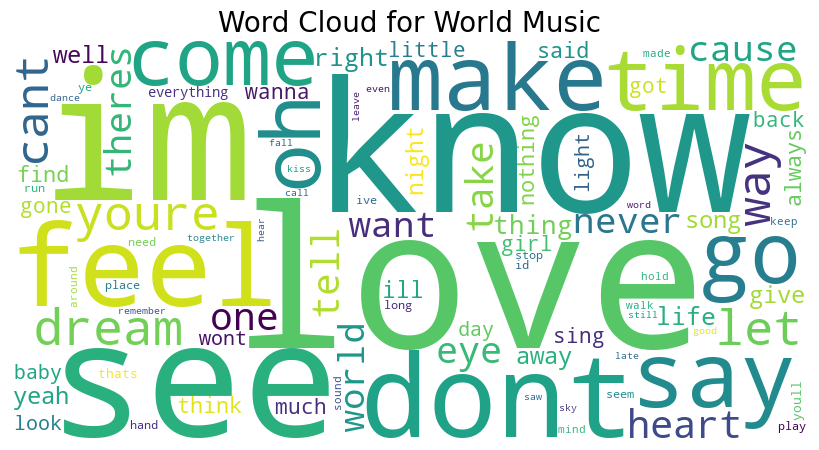

In [99]:

merged_df = merged_df.reset_index(drop=True) 

# --- 1. EXPLORATORY DATA ANALYSIS (EDA) ---

# Word Frequencies (Word Clouds)
def plot_wordcloud(text, title=None):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          max_words=200,
                          min_font_size=10).generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    if title:
        plt.title(title, fontsize=20)
    plt.show()

for genre in merged_df['parent_genre_new'].unique():
    genre_text = " ".join(merged_df[merged_df['parent_genre_new'] == genre]['lyrics'])
    plot_wordcloud(genre_text, title=f"Word Cloud for {genre}")




## Sentiment Analysis by Genre

### Visualizing Sentiment Distribution


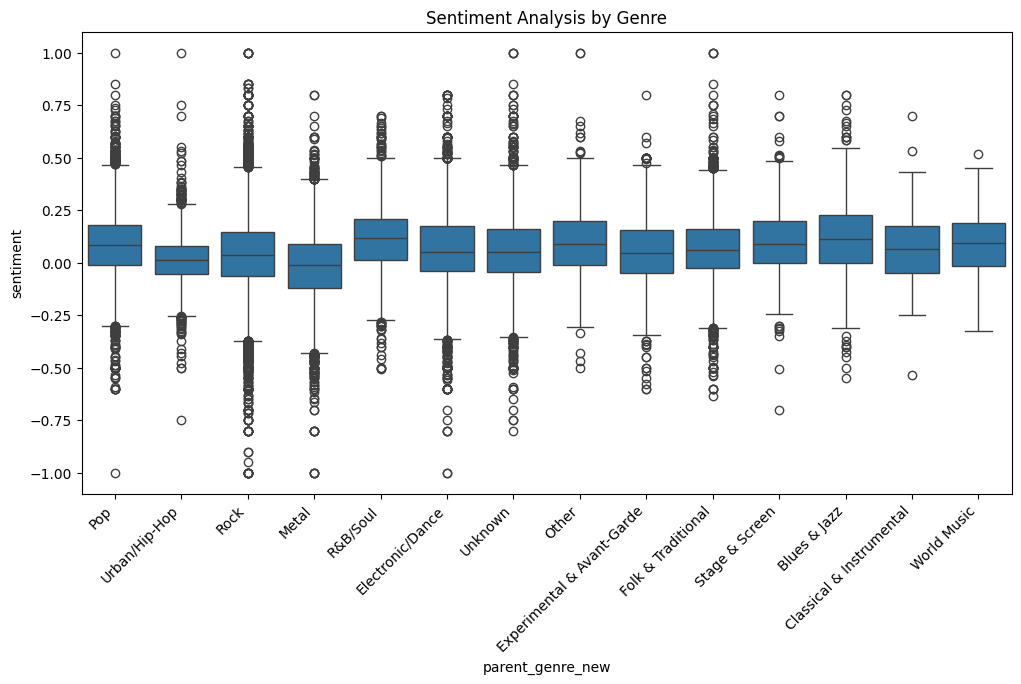

In [100]:
# Sentiment Analysis by Genre
plt.figure(figsize=(12, 6))
sns.boxplot(x='parent_genre_new', y='sentiment', data=merged_df.copy()) 
plt.title('Sentiment Analysis by Genre')
plt.xticks(rotation=45, ha='right')
plt.show()



## Lyric Length Comparison by Genre

### Visualizing Lyric Length Distribution

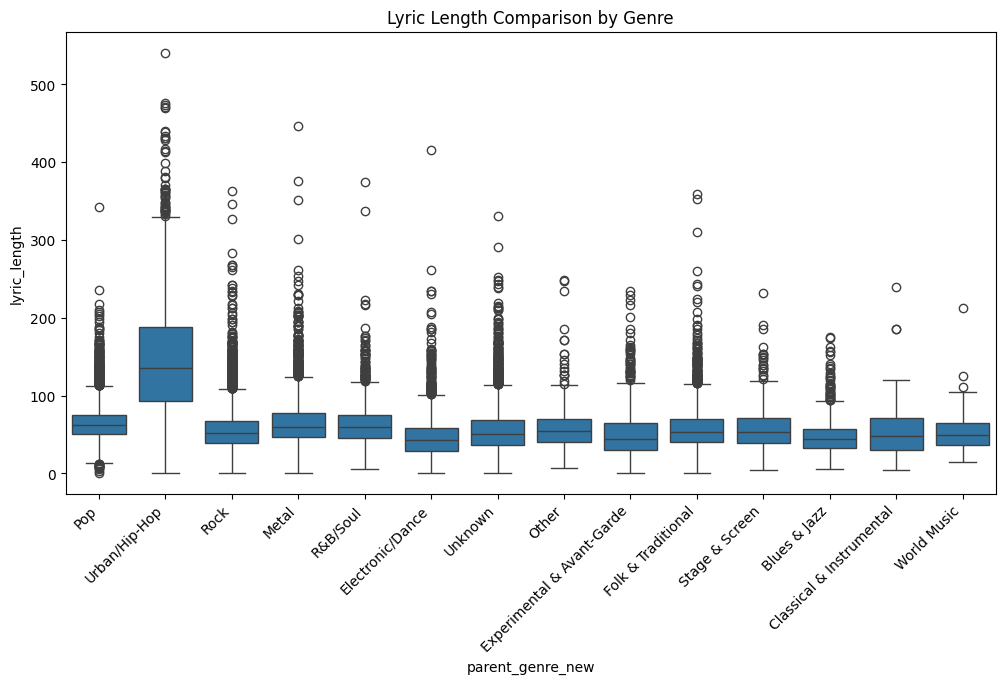

In [101]:
# Lyric Length Comparison 
merged_df['lyric_length'] = merged_df['lyrics'].str.split().str.len()
plt.figure(figsize=(12, 6))
sns.boxplot(x='parent_genre_new', y='lyric_length', data=merged_df.copy()) 
plt.title('Lyric Length Comparison by Genre')
plt.xticks(rotation=45, ha='right')
plt.show()


## N-gram and TF-IDF Analysis

### N-gram Analysis (Example: Bigrams)

- **Function**: `get_top_ngrams` extracts the top `n`-grams (e.g., bigrams) from a corpus.
- **Process**: For each genre, the top 10 most frequent bigrams are identified and printed.
- **Purpose**: To understand common word pairs or phrases in lyrics for different genres.

### TF-IDF Analysis

- **TF-IDF Vectorizer**: Used to convert lyrics into TF-IDF features, capturing the importance of words in the context of the entire corpus.
- **Process**: For each genre, the top 10 words with the highest average TF-IDF scores are identified and printed.
- **Purpose**: To highlight the most distinctive words for each genre based on their term frequency-inverse document frequency.

### Feature Engineering

- **Objective**: To prepare and enhance features for model training and analysis.
- **Next Steps**: Utilize `features_df`, a copy of `merged_df`, for further feature engineering tasks.

These analyses help to uncover patterns in the text data and create meaningful features for classification and other machine learning tasks.


In [64]:
# N-gram Analysis (Example: Bigrams - 2-word phrases)
def get_top_ngrams(corpus, n=2, top_k=10):
    all_ngrams = [gram for text in corpus for gram in ngrams(text.split(), n)]
    ngram_freq = Counter(all_ngrams)
    return ngram_freq.most_common(top_k)

for genre in merged_df['parent_genre_new'].unique():
    genre_corpus = merged_df[merged_df['parent_genre_new'] == genre]['lyrics']
    top_bigrams = get_top_ngrams(genre_corpus, n=2, top_k=10)
    print(f"Top 10 bigrams for {genre}: {top_bigrams}")

# TF-IDF Analysis
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['lyrics'])

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Print top TF-IDF words for each genre
for genre in merged_df['parent_genre_new'].unique():
    genre_index = merged_df[merged_df['parent_genre_new'] == genre].index  
    genre_tfidf = tfidf_matrix[genre_index]  
    avg_tfidf = genre_tfidf.mean(axis=0).A1 
    top_tfidf_indices = avg_tfidf.argsort()[-10:][::-1] 
    top_words = [feature_names[i] for i in top_tfidf_indices]
    print(f"Top 10 TF-IDF words for {genre}: {top_words}")

# --- 2. FEATURE ENGINEERING ---

# Create a copy of merged_df for feature engineering
features_df = merged_df.copy()


Top 10 bigrams for Pop: [(('dont', 'know'), 658), (('let', 'go'), 584), (('dont', 'wanna'), 362), (('im', 'gonna'), 350), (('ive', 'got'), 328), (('feel', 'like'), 281), (('every', 'time'), 276), (('dont', 'want'), 273), (('oh', 'yeah'), 266), (('youve', 'got'), 255)]
Top 10 bigrams for Urban/Hip-Hop: [(('dont', 'know'), 160), (('feel', 'like'), 94), (('every', 'time'), 81), (('know', 'im'), 81), (('dont', 'wanna'), 78), (('give', 'fuck'), 77), (('lets', 'go'), 72), (('dont', 'want'), 66), (('brand', 'new'), 65), (('cant', 'even'), 63)]
Top 10 bigrams for Rock: [(('dont', 'know'), 1328), (('let', 'go'), 864), (('ive', 'got'), 829), (('youve', 'got'), 612), (('dont', 'want'), 590), (('theres', 'nothing'), 554), (('im', 'gonna'), 535), (('feel', 'like'), 498), (('cant', 'see'), 465), (('dont', 'wanna'), 447)]
Top 10 bigrams for Metal: [(('dont', 'know'), 165), (('let', 'go'), 159), (('set', 'free'), 136), (('close', 'eyes'), 124), (('cant', 'see'), 113), (('left', 'behind'), 113), (('far

In [65]:

# Parameters
num_samples = 900
num_genres = 10
SEED = 42  

# Create a copy of the DataFrame
analysis_df = merged_df.copy()

# Get the top genres by count
top_genres = analysis_df['parent_genre_new'].value_counts().nlargest(num_genres).index

# Filter the DataFrame to include only rows with top genres
analysis_df = analysis_df[analysis_df['parent_genre_new'].isin(top_genres)]

# Define a function to sample or skip groups based on size
def sample_or_skip(group):
    if len(group) >= num_samples:
        return group.sample(n=num_samples, random_state=SEED)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if not enough samples

# Apply the sampling function to each genre group
analysis_df = analysis_df.groupby('parent_genre_new').apply(sample_or_skip).reset_index(drop=True)

# Print the count of each genre in the resulting DataFrame
# print(analysis_df['parent_genre_new'].value_counts()
top_genres

Index(['Rock', 'Pop', 'Metal', 'Unknown', 'Electronic/Dance',
       'Folk & Traditional', 'Urban/Hip-Hop', 'R&B/Soul', 'Blues & Jazz',
       'Experimental & Avant-Garde'],
      dtype='object', name='parent_genre_new')

## Cosine Similarity Heatmap for Music Genres

### Description

This visualization provides a heatmap of the cosine similarity between different music genres based on their TF-IDF representations of lyrics. Cosine similarity measures the cosine of the angle between two non-zero vectors, which in this case represents the similarity between genre vectors.

### Steps

1. **TF-IDF Vectorization**: Convert lyrics into TF-IDF features.
2. **Mean TF-IDF Calculation**: Compute the mean TF-IDF score for each genre.
3. **Cosine Similarity**: Calculate pairwise cosine similarity between genre vectors.
4. **Heatmap Visualization**: Display the similarity matrix using a heatmap.

### Heatmap Details

- **Color Map**: `coolwarm`, illustrating the similarity levels with colors.
- **Annotations**: Displayed for each cell to provide exact similarity values.
- **Labels**: Genre names are used for both x and y axes for clarity.

The heatmap helps identify which genres are more similar to each other based on their lyrical content, providing insights into genre relationships and distinctions.


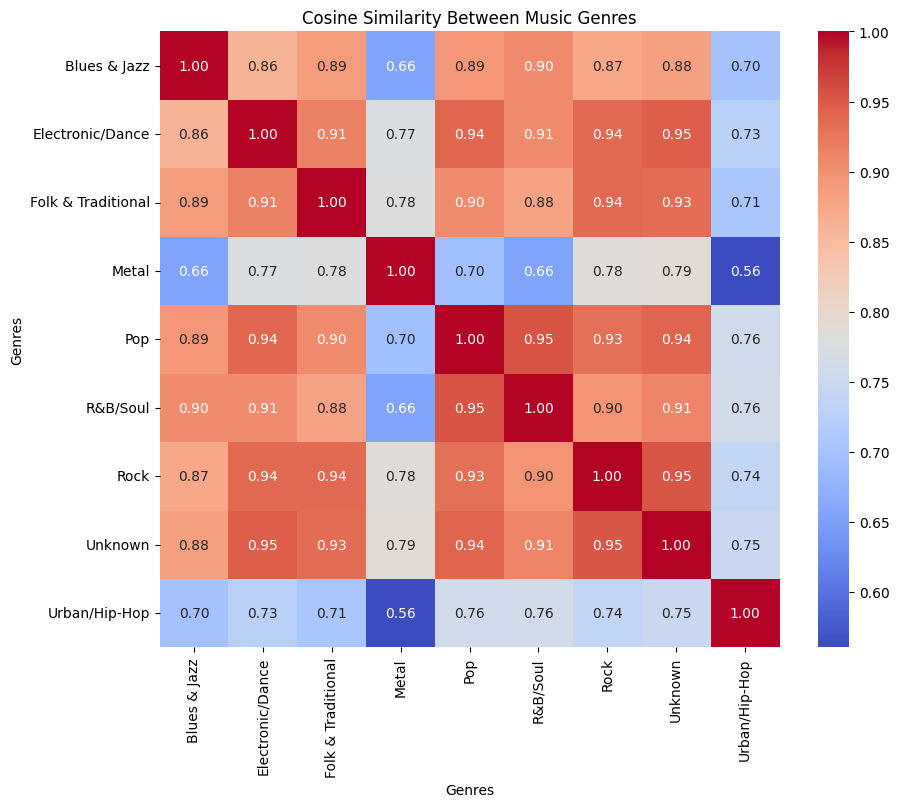

In [66]:

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Transform the 'Lyric' column to a TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(analysis_df['lyrics'])

# Create a DataFrame with genres as index and TF-IDF features as columns
genre_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=analysis_df['parent_genre_new'], columns=vectorizer.get_feature_names_out())

# Calculate the mean TF-IDF score for each genre
mean_tfidf_by_genre = genre_tfidf.groupby('parent_genre_new').mean()

# Calculate the pairwise cosine similarity between genre vectors
similarity_matrix = cosine_similarity(mean_tfidf_by_genre)
similarity_df = pd.DataFrame(similarity_matrix, index=mean_tfidf_by_genre.index, columns=mean_tfidf_by_genre.index)

# Set the plot size
plt.figure(figsize=(10, 8))

# Create a heatmap to visualize the similarity matrix
sns.heatmap(similarity_df, 
            annot=True,   # Optionally add annotations to each cell
            fmt=".2f",    # Formatting the annotation if `annot` is True
            cmap='coolwarm',  # Color map style
            xticklabels=similarity_df.columns,  # Ensuring labels are genre names
            yticklabels=similarity_df.index)    # Ensuring labels are genre names

# Add titles and labels for clarity
plt.title('Cosine Similarity Between Music Genres')
plt.xlabel('Genres')
plt.ylabel('Genres')

# Show the plot
plt.show()


In [67]:

# Get all combinations of 5 genres
genre_combinations = list(combinations(similarity_df.index, 5))

# Function to calculate the mean similarity of a combination
def mean_similarity(combination):
    # Extract the sub-matrix of the similarity matrix for the given combination
    sub_matrix = similarity_df.loc[combination, combination]
    # Calculate the mean of the upper triangle of the matrix, excluding the diagonal
    mean_sim = np.mean([sub_matrix.iloc[i, j] for i in range(len(combination)) for j in range(i+1, len(combination))])
    return mean_sim

# Calculate mean similarity for each combination
mean_similarities = [(combo, mean_similarity(combo)) for combo in genre_combinations]

# Find the combination with the smallest mean similarity
min_similarity_combo = min(mean_similarities, key=lambda x: x[1])

print("Combination with the smallest mean similarity:", min_similarity_combo[0])
print("Mean similarity:", min_similarity_combo[1])

# Find the combination with the largest mean similarity
max_similarity_combo = max(mean_similarities, key=lambda x: x[1])

print("Combination with the maximum mean similarity:", max_similarity_combo[0])
print("Mean similarity:", max_similarity_combo[1])


Combination with the smallest mean similarity: ('Blues & Jazz', 'Folk & Traditional', 'Metal', 'R&B/Soul', 'Urban/Hip-Hop')
Mean similarity: 0.7486573281724216
Combination with the maximum mean similarity: ('Electronic/Dance', 'Folk & Traditional', 'Pop', 'Rock', 'Unknown')
Mean similarity: 0.9335075909625482


In [68]:

# Drop rows where the genre column is in the genres associated with minimum similarity
min_similarity_df = merged_df[merged_df['parent_genre_new'].isin(min_similarity_combo[0])]

# Drop rows where the genre column is in the genres associated with maximum similarity
max_similarity_df = merged_df[merged_df['parent_genre_new'].isin(max_similarity_combo[0])]

# Print genre distribution in the minimum similarity DataFrame
print("Minimum Similarity DF")
print(min_similarity_df['parent_genre_new'].value_counts())

# Print genre distribution in the maximum similarity DataFrame
print("\nMaximum Similarity DF")
print(max_similarity_df['parent_genre_new'].value_counts())



Minimum Similarity DF
parent_genre_new
Metal                 6656
Folk & Traditional    3859
Urban/Hip-Hop         2720
R&B/Soul              2252
Blues & Jazz           904
Name: count, dtype: int64

Maximum Similarity DF
parent_genre_new
Rock                  25436
Pop                    9454
Unknown                4949
Electronic/Dance       4284
Folk & Traditional     3859
Name: count, dtype: int64


## t-SNE Visualization of Music Genres

### Description

This visualization uses t-SNE (t-Distributed Stochastic Neighbor Embedding) to reduce the dimensionality of TF-IDF vectors derived from song lyrics, enabling us to visualize the relationships between different music genres in a 2D space. t-SNE is useful for visualizing high-dimensional data by preserving the relative distances and local structures.

### Visualizations

1. **All Genres**:
   - Displays the 2D t-SNE plot for all available genres, showing how they are distributed based on their lyrical content.

2. **Least Similar Genres**:
   - Focuses on the genres that are least similar to each other, as determined by cosine similarity. This plot highlights the distinctions between these less similar genres.

3. **Most Similar Genres**:
   - Shows the genres that are most similar to each other. This plot helps in understanding the proximity and overlap between these closely related genres.

### Plot Details

- **Axes**: 
  - `tsne-2d-one` and `tsne-2d-two` represent the two dimensions after t-SNE transformation.
  
- **Color Palette**: 
  - Uses a rainbow color palette to distinguish between genres.

- **Legend**: 
  - The legend is placed to the right of the plot for better readability.

- **Axis Limits**: 
  - Set based on the Interquartile Range (IQR) to ensure that the plot focuses on the central distribution of data points.

### Code Explanation

- **Data Filtering**: 
  - Filters the DataFrame to include only the genres specified in `genre_subset`.

- **Vectorization**: 
  - Converts lyrics into TF-IDF features.

- **Dimensionality Reduction**: 
  - Applies t-SNE to reduce the TF-IDF matrix to two dimensions.

- **Plotting**: 
  - Creates scatter plots for the t-SNE results with genres color-coded, and adjusts axis limits based on IQR for better visualization.

These visualizations aid in understanding the distribution and similarity of different music genres based on their lyrical content.


Index(['id', 'parent_genre_new', 'lyrics', 'lang', 'sentiment', 'Lyric_Count',
       'lyric_length'],
      dtype='object')
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8100 samples in 0.012s...
[t-SNE] Computed neighbors for 8100 samples in 3.949s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8100
[t-SNE] Computed conditional probabilities for sample 2000 / 8100
[t-SNE] Computed conditional probabilities for sample 3000 / 8100
[t-SNE] Computed conditional probabilities for sample 4000 / 8100
[t-SNE] Computed conditional probabilities for sample 5000 / 8100
[t-SNE] Computed conditional probabilities for sample 6000 / 8100
[t-SNE] Computed conditional probabilities for sample 7000 / 8100
[t-SNE] Computed conditional probabilities for sample 8000 / 8100
[t-SNE] Computed conditional probabilities for sample 8100 / 8100
[t-SNE] Mean sigma: 0.411473
[t-SNE] KL divergence after 250 iterations with early exaggeration: 164.927414
[t-SNE] KL divergence after 300

C:\Users\Asus\AppData\Local\Temp\ipykernel_22144\1396092676.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Asus\AppData\Local\Temp\ipykernel_22144\1396092676.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4500 samples in 0.016s...
[t-SNE] Computed neighbors for 4500 samples in 1.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4500
[t-SNE] Computed conditional probabilities for sample 2000 / 4500
[t-SNE] Computed conditional probabilities for sample 3000 / 4500
[t-SNE] Computed conditional probabilities for sample 4000 / 4500
[t-SNE] Computed conditional probabilities for sample 4500 / 4500
[t-SNE] Mean sigma: 0.395560
[t-SNE] KL divergence after 250 iterations with early exaggeration: 143.311417
[t-SNE] KL divergence after 300 iterations: 8.644531


C:\Users\Asus\AppData\Local\Temp\ipykernel_22144\1396092676.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Asus\AppData\Local\Temp\ipykernel_22144\1396092676.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



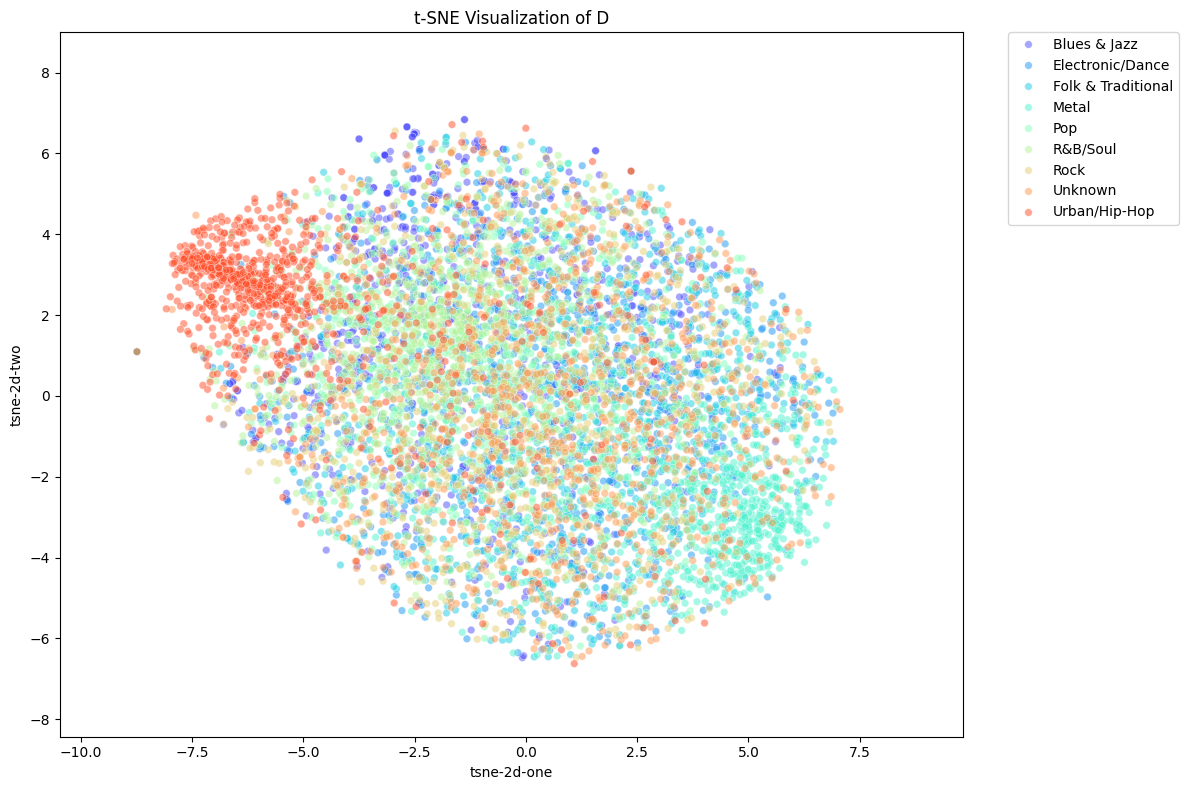

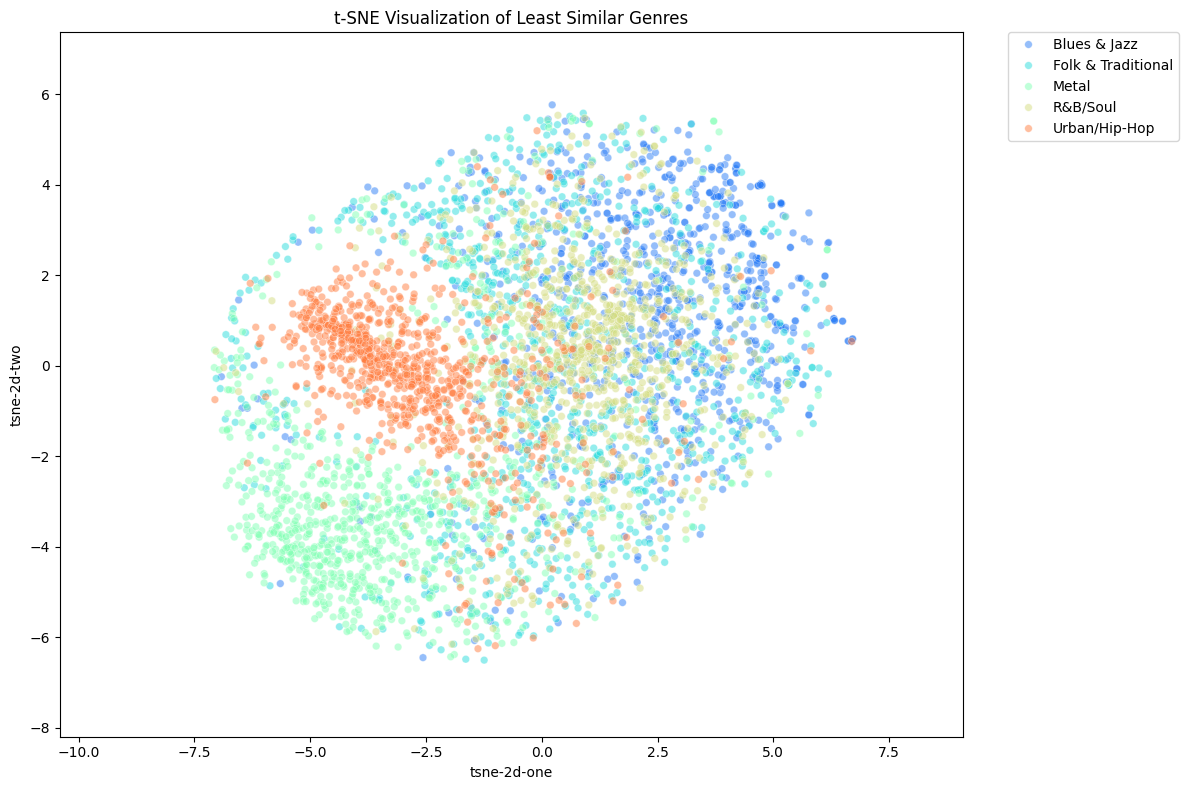

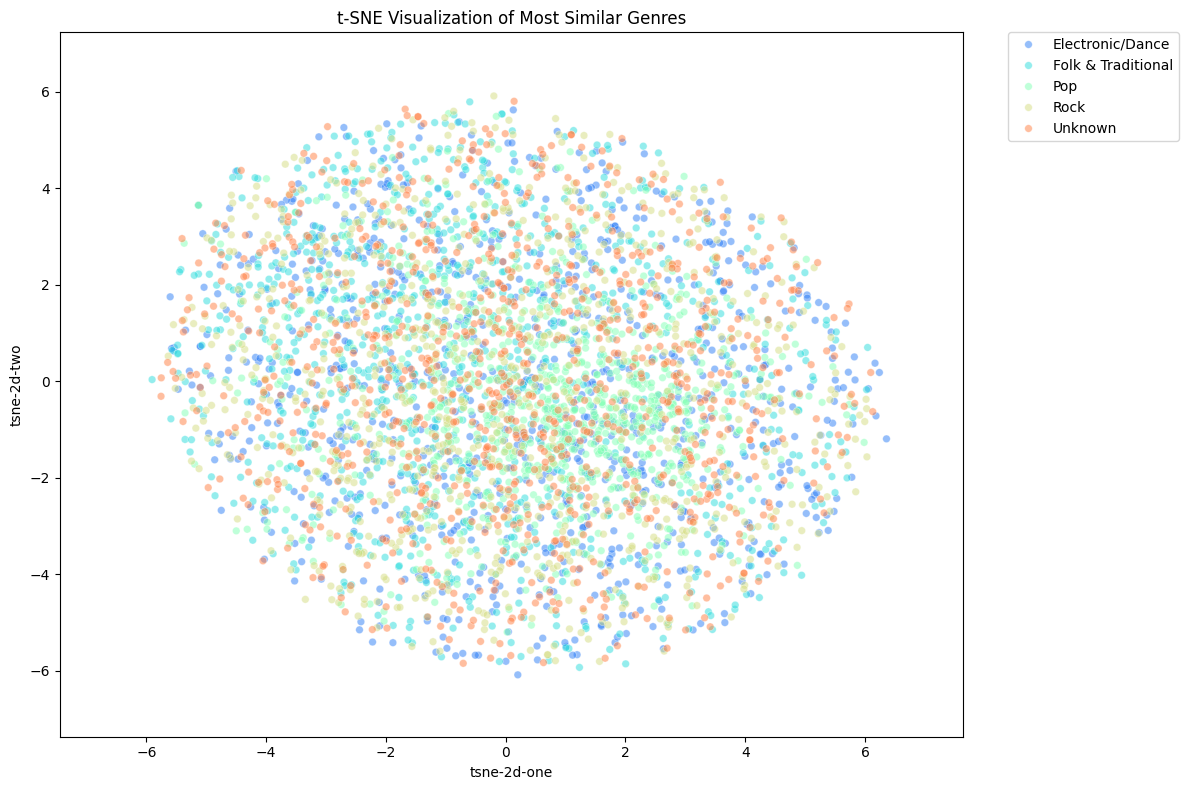

In [69]:

def plot_tsne_for_genres(df, genre_subset, title_suffix):
    # Filter the DataFrame for the genres in genre_subset
    filtered_df = df[df['parent_genre_new'].isin(genre_subset)]
    
    # Vectorize the lyrics
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(filtered_df['lyrics'])
    
    # Reduce dimensions with t-SNE
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X.toarray())
    
    # Add t-SNE results to the DataFrame
    filtered_df['tsne-2d-one'] = tsne_results[:, 0]
    filtered_df['tsne-2d-two'] = tsne_results[:, 1]

    # Calculate IQR for scaling axis
    Q1_tsne_one = np.percentile(filtered_df['tsne-2d-one'], 25)
    Q3_tsne_one = np.percentile(filtered_df['tsne-2d-one'], 75)
    IQR_tsne_one = Q3_tsne_one - Q1_tsne_one
    Q1_tsne_two = np.percentile(filtered_df['tsne-2d-two'], 25)
    Q3_tsne_two = np.percentile(filtered_df['tsne-2d-two'], 75)
    IQR_tsne_two = Q3_tsne_two - Q1_tsne_two

    # Set axis limits
    x_min, x_max = Q1_tsne_one - 1.5 * IQR_tsne_one, Q3_tsne_one + 1.5 * IQR_tsne_one
    y_min, y_max = Q1_tsne_two - 1.5 * IQR_tsne_two, Q3_tsne_two + 1.5 * IQR_tsne_two

    # Plotting
    plt.figure(figsize=(12, 8))  
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="parent_genre_new",
        palette=sns.color_palette("rainbow", len(genre_subset)),
        data=filtered_df,
        legend="full",
        s=30,
        alpha=0.5
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f't-SNE Visualization of {title_suffix}')
    
    # Adjust the legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)  # Places legend to the right of the plot
    
    plt.tight_layout()  


# Results 
print(analysis_df.columns)
plot_tsne_for_genres(analysis_df, analysis_df['parent_genre_new'].unique(), "D")
plot_tsne_for_genres(analysis_df, min_similarity_combo[0], "Least Similar Genres")
plot_tsne_for_genres(analysis_df, max_similarity_combo[0], "Most Similar Genres")


## Pie Chart of Song Distribution per Genre (Minimum Similarity)

### Description

This pie chart visualizes the distribution of songs across different genres within the subset of genres with minimum similarity. It provides an overview of how songs are distributed among these less similar genres.


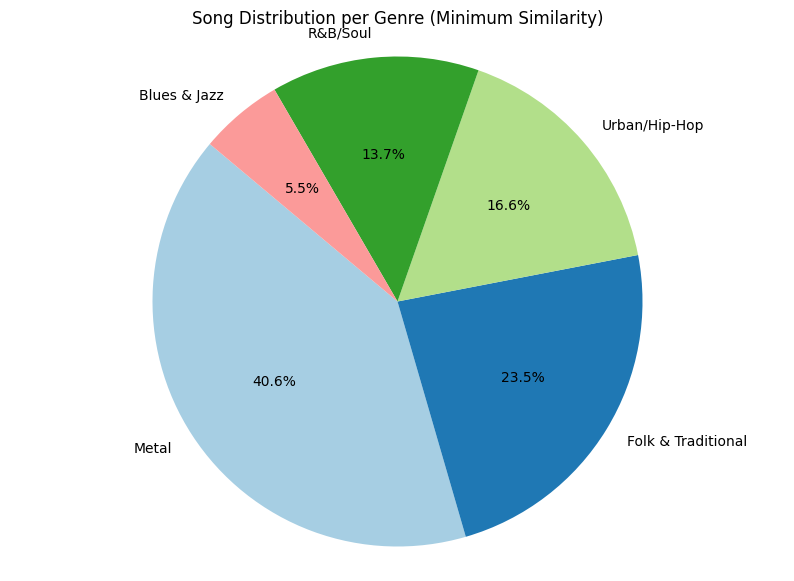

In [70]:

# Get the genre distribution
genre_counts = min_similarity_df['parent_genre_new'].value_counts()

# Plot pie chart
plt.figure(figsize=(10, 7))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(genre_counts))))
plt.title('Song Distribution per Genre (Minimum Similarity)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()


## Pairwise Relationships with Genre

### Description

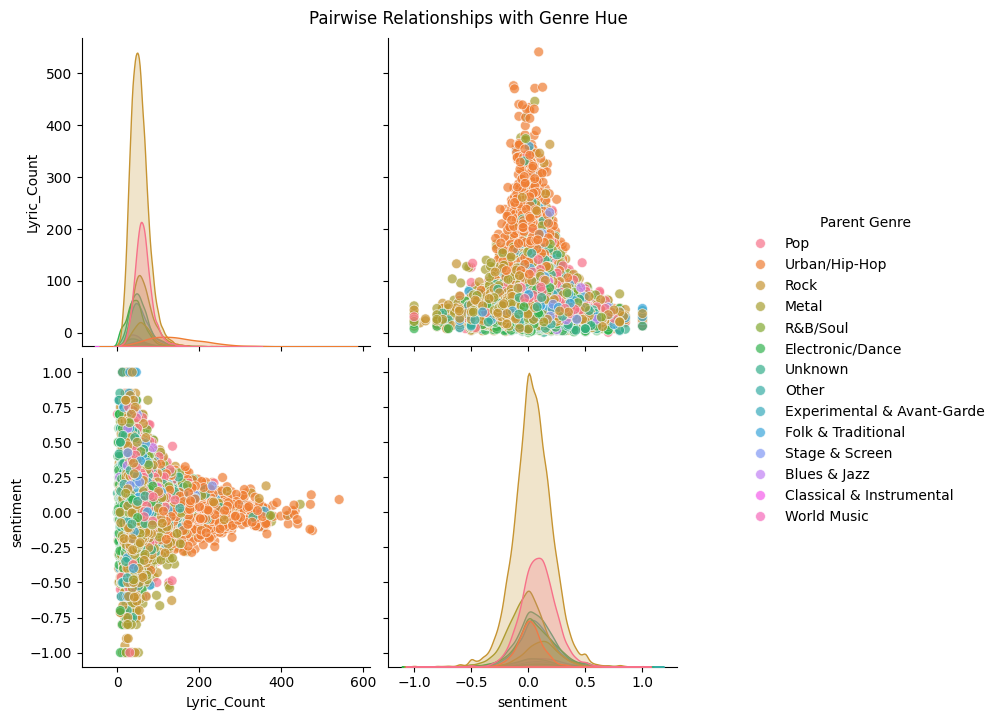

In [89]:

# number of unique genres
num_genres = len(merged_df['parent_genre_new'].unique())

# Generate a color palette with enough colors
palette = sns.color_palette("husl", num_genres)  # or "tab20"

# Create the pairplot
pairplot = sns.pairplot(
    merged_df[['Lyric_Count', 'sentiment', 'parent_genre_new']],
    hue='parent_genre_new',
    palette=palette,
    diag_kind='kde',  # Use KDE plots on the diagonal
    markers='o',      # Use markers for scatter plots
    plot_kws={'alpha': 0.7, 's': 50},
    height=5.0        
)

# Add a title to the pairplot
pairplot.fig.suptitle('Pairwise Relationships with Genre', y=1.02)

# Customize the legend
pairplot._legend.set_bbox_to_anchor((1.05, 0.5))
pairplot._legend.set_title('Parent Genre')

# Show the plot
plt.show()


## Pairwise Relationships by Genre

### Description

This set of scatter plots illustrates the relationship between `Lyric_Count` and `sentiment` for each genre in the dataset. The plots are arranged in a grid to provide a clear view of how these features interact across different genres.


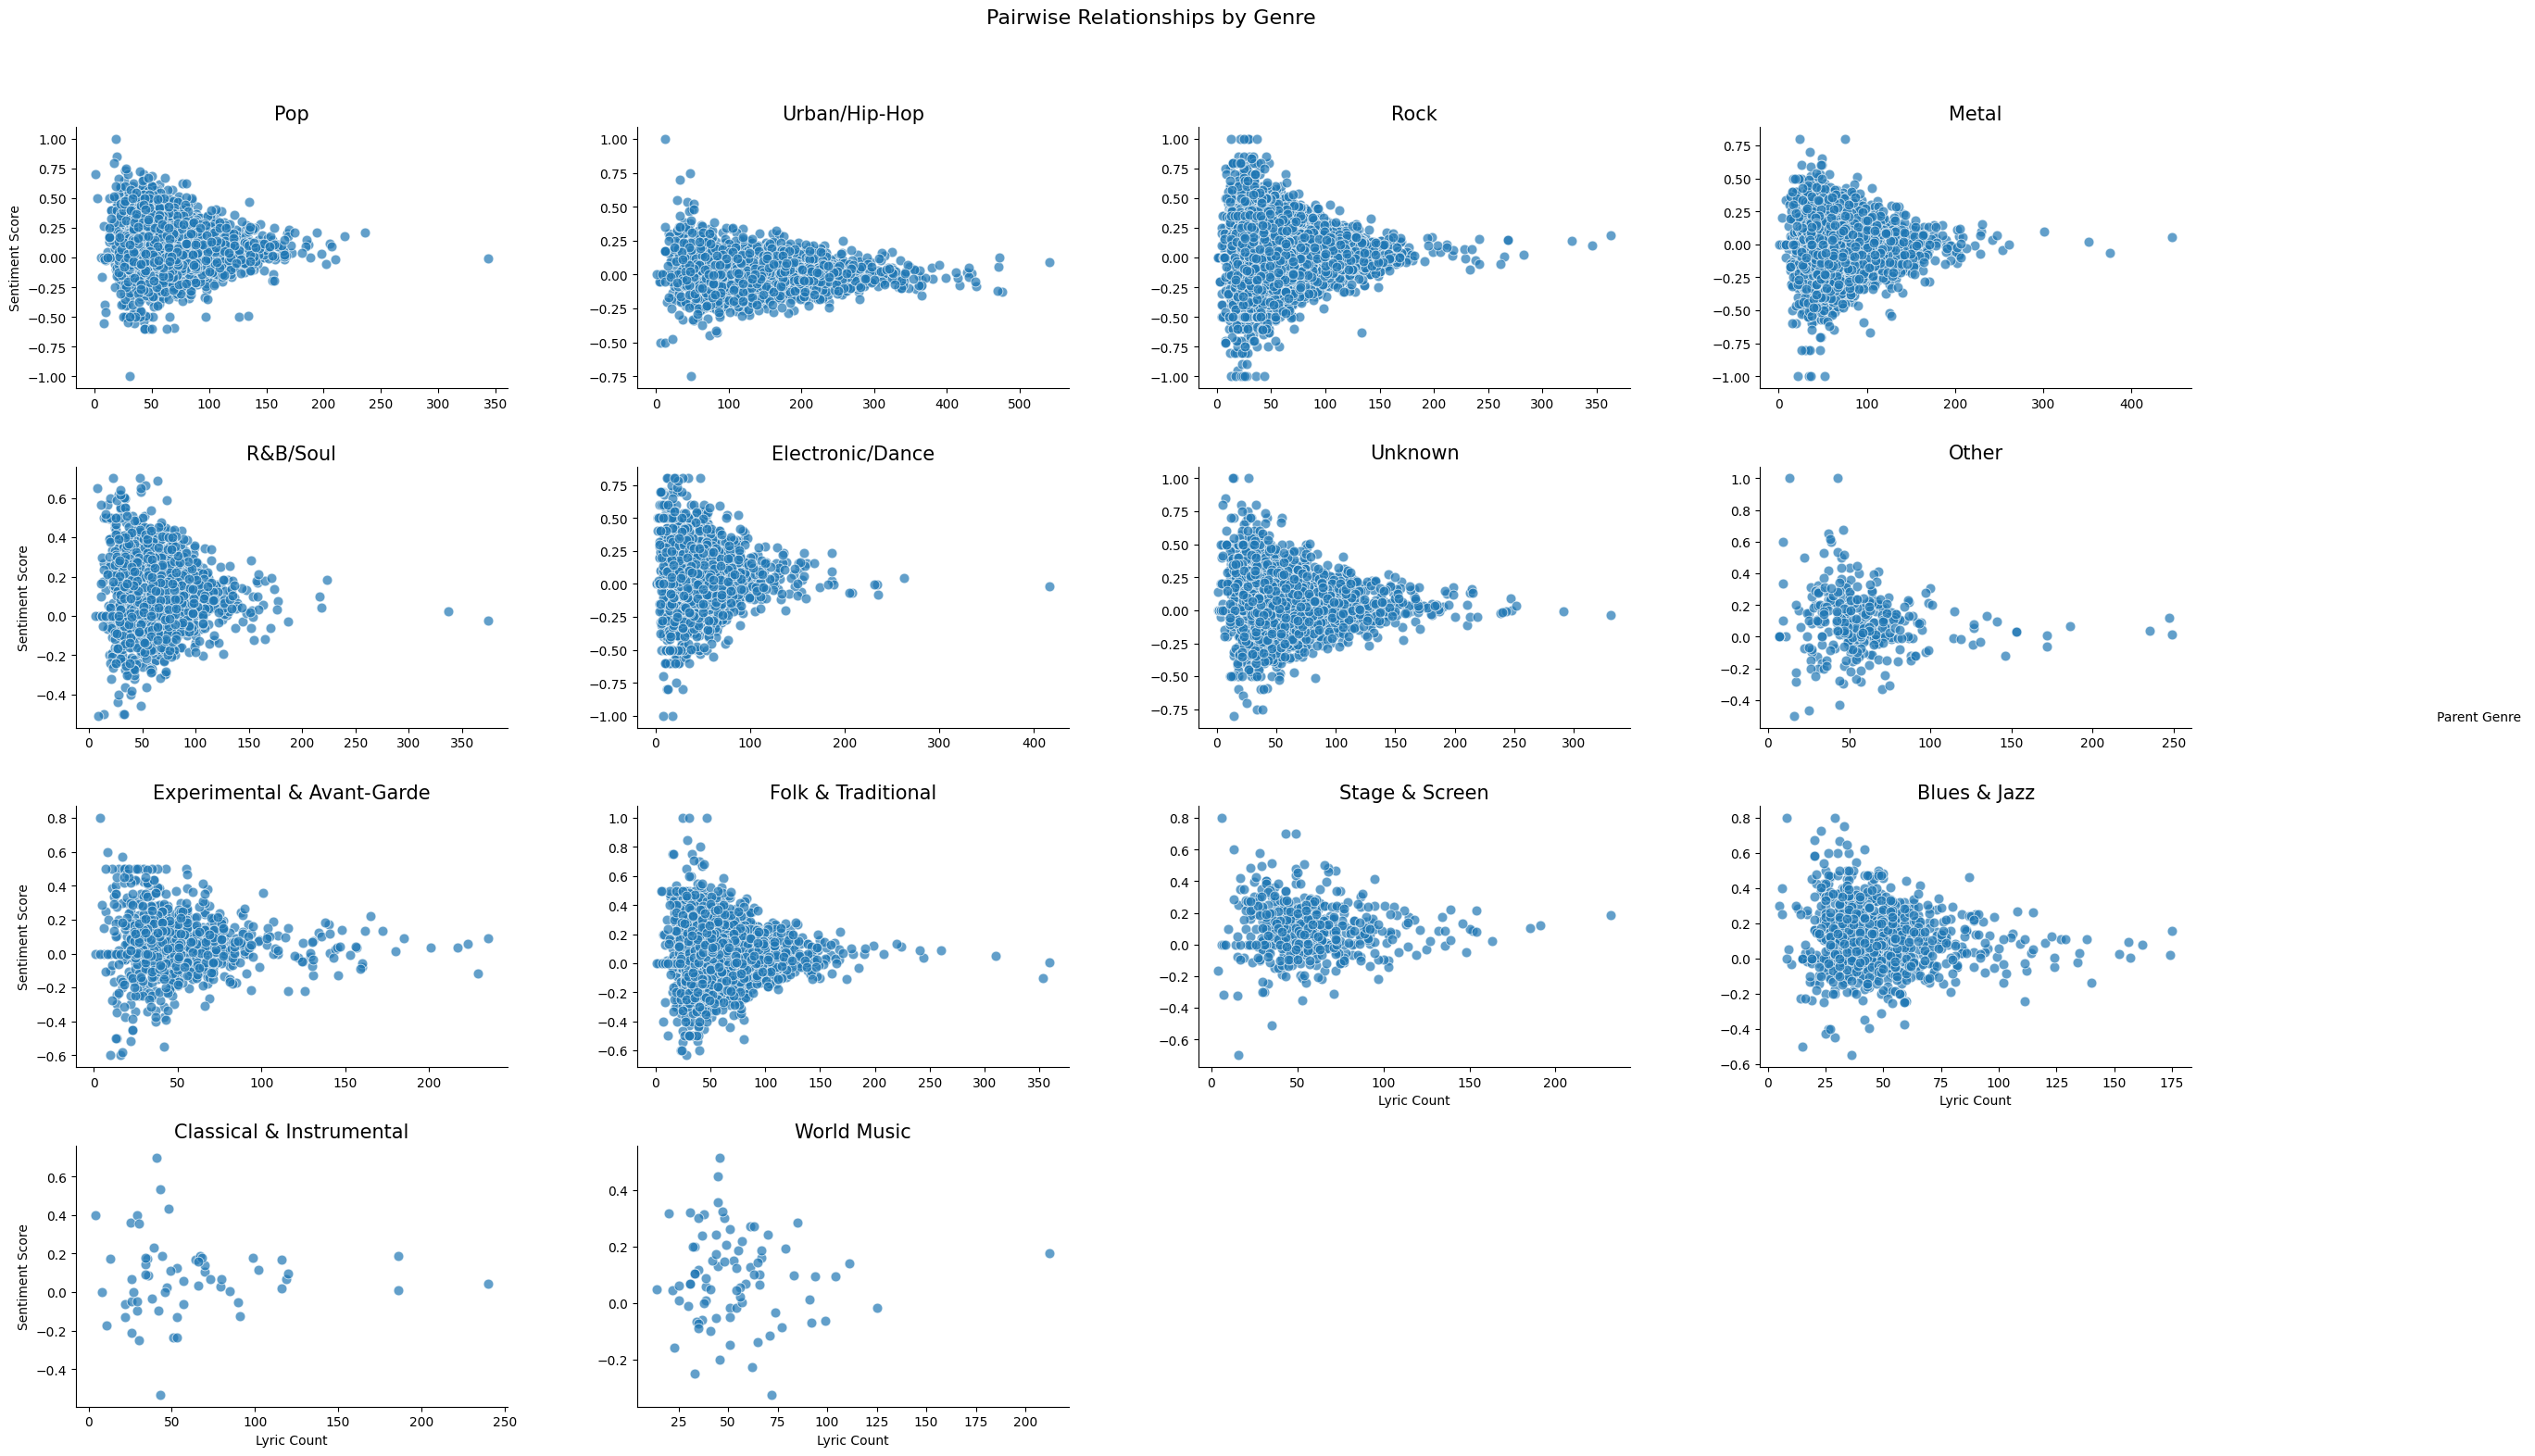

In [98]:

import matplotlib.pyplot as plt

# Create a FacetGrid with subplots for each genre
g = sns.FacetGrid(
    merged_df, 
    col='parent_genre_new', 
    col_wrap=4, 
    height=4,
    aspect=1.5,  
    sharex=False,  
    sharey=False   
)

# Map scatter plots to the grid
g.map(sns.scatterplot, 'Lyric_Count', 'sentiment', alpha=0.7, s=60)

# Add titles and labels to each subplot
g.set_axis_labels('Lyric Count', 'Sentiment Score')
g.set_titles(col_template="{col_name}", size=15)  

# Adjust the layout to prevent overlap
g.fig.subplots_adjust(top=0.9, wspace=0.3, hspace=0.3)

# Add a main title
g.fig.suptitle('Pairwise Relationships by Genre', fontsize=16)

# Customize the legend
g.add_legend(title='Parent Genre', bbox_to_anchor=(1.05, 0.5), loc='center left')

# Show the plot
plt.show()


In [78]:
genre_stats = merged_df.groupby('parent_genre_new').agg({
    'Lyric_Count': ['mean', 'median', 'std'],
    'sentiment': ['mean', 'median', 'std']
})

# Print Genre stats
genre_stats


Lyric_Count                   sentiment            \
                                  mean median        std      mean    median   
parent_genre_new                                                               
Blues & Jazz                 48.030973   44.0  22.882412  0.116969  0.110873   
Classical & Instrumental     59.783333   47.5  44.140796  0.072391  0.066597   
Electronic/Dance             45.440943   43.0  25.719214  0.062865  0.050074   
Experimental & Avant-Garde   51.371393   44.0  32.808989  0.052646  0.047273   
Folk & Traditional           57.774294   53.0  27.330696  0.065721  0.060000   
Metal                        65.175631   60.0  28.600268 -0.016964 -0.011237   
Other                        59.422581   54.0  33.009935  0.095343  0.090757   
Pop                          64.025280   62.0  22.051547  0.083982  0.082279   
R&B/Soul                     62.615897   59.0  26.975520  0.114429  0.115566   
Rock                         54.550991   52.0  23.312547  0.038488  0.035222   
Stage & Screen               58.178000   53.0  29.568139  0.096870  0.090160   
Unknown                      55.976359   51.0  28.842337  0.056875  0.051282   
Urban/Hip-Hop               145.486397  136.0  71.482529  0.014239  0.011679   
World Music                  54.650602   49.0  27.807015  0.087435  0.094192   

                                      
                                 std  
parent_genre_new                      
Blues & Jazz                0.181097  
Classical & Instrumental    0.201103  
Electronic/Dance            0.195061  
Experimental & Avant-Garde  0.183777  
Folk & Traditional          0.164387  
Metal                       0.169871  
Other                       0.197715  
Pop                         0.154571  
R&B/Soul                    0.160718  
Rock                        0.173948  
Stage & Screen              0.168071  
Unknown                     0.174845  
Urban/Hip-Hop               0.119399  
World Music                 0.158891

## Latent Dirichlet Allocation (LDA) Topic Modeling

### Description

Latent Dirichlet Allocation (LDA) is used to uncover the underlying topics within a collection of documents. In this analysis, LDA was applied to the TF-IDF matrix of song lyrics to identify common themes across genres.

### LDA Model Details

- **Number of Topics**: 10
- **Random State**: 42 (for reproducibility)

In [94]:

# Initialize and fit LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda_features = lda.fit_transform(tfidf_matrix)

# Get the feature names (words) from the TF-IDF vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to get top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic {topic_idx}: {' '.join(top_words)}")

# Print top 10 words for each topic
print_top_words(lda, tfidf_feature_names, 10)

# Convert lda_features to DataFrame
lda_df = pd.DataFrame(lda_features, columns=[f"Topic {i}" for i in range(lda_features.shape[1])])

# Display the first few rows of topic distributions
print(lda_df.head())


Topic 0: cosigns discorporates birtch disputing fashions candlew condition allnight ghana glories
Topic 1: beacons fey desente decorative amending gravitate bandidi cannons golf fadeout
Topic 2: angering deut carryin fanerio deutgo angies ahahahaaa hasten carted blahzy
Topic 3: colvin cosmogenesis bobba cumming crochet gash hatvans dingdongdong characteristic butbiu
Topic 4: archandroid evase betrayed bicycling bedumbedumdum digable asswhoopin documented apricot dehydrate
Topic 5: diy halfdestroyed disobey gnat critique eojeui chula capass filtering bongo
Topic 6: gooi detentions fallleaves handy dread churchbell clumsy fulfillment failsafe conductor
Topic 7: deere adora asparagus downin dadadadadadadadadammit expectancies firebreathers emmersed cowes hamlet
Topic 8: bitsy foreshadow foranother dedicates cavarly flodgin bicycling beet buildabear globes
Topic 9: asswhoopin halright coalliance birtch braying chodakara abruptly dedicate endings anisotropies
    Topic 0   Topic 1   Topic 2

------------------------ **End** ------------------------